This case is an attempt to evaluate and predict the profitability of a stock, use different approaches and practices. In the future, there will be further refinement. There are a lot of good materials in the book Yves Hilpisch python for financial calculations, there is a lot of material for forecasting in this book

In [28]:
import sys
from tqdm import tqdm
import pandas as pd
import yfinance as yf
import numpy as np
import warnings
import itertools
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as scs
from scipy.optimize import minimize
from itertools import product

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


import matplotlib.pyplot as plt
import warnings
%matplotlib inline

plt.style.use('seaborn')

plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

Создадим список интересующих нас акций для анализа, берем произвольно, без цели отобрать определенные акции

[*********************100%***********************]  1 of 1 completed


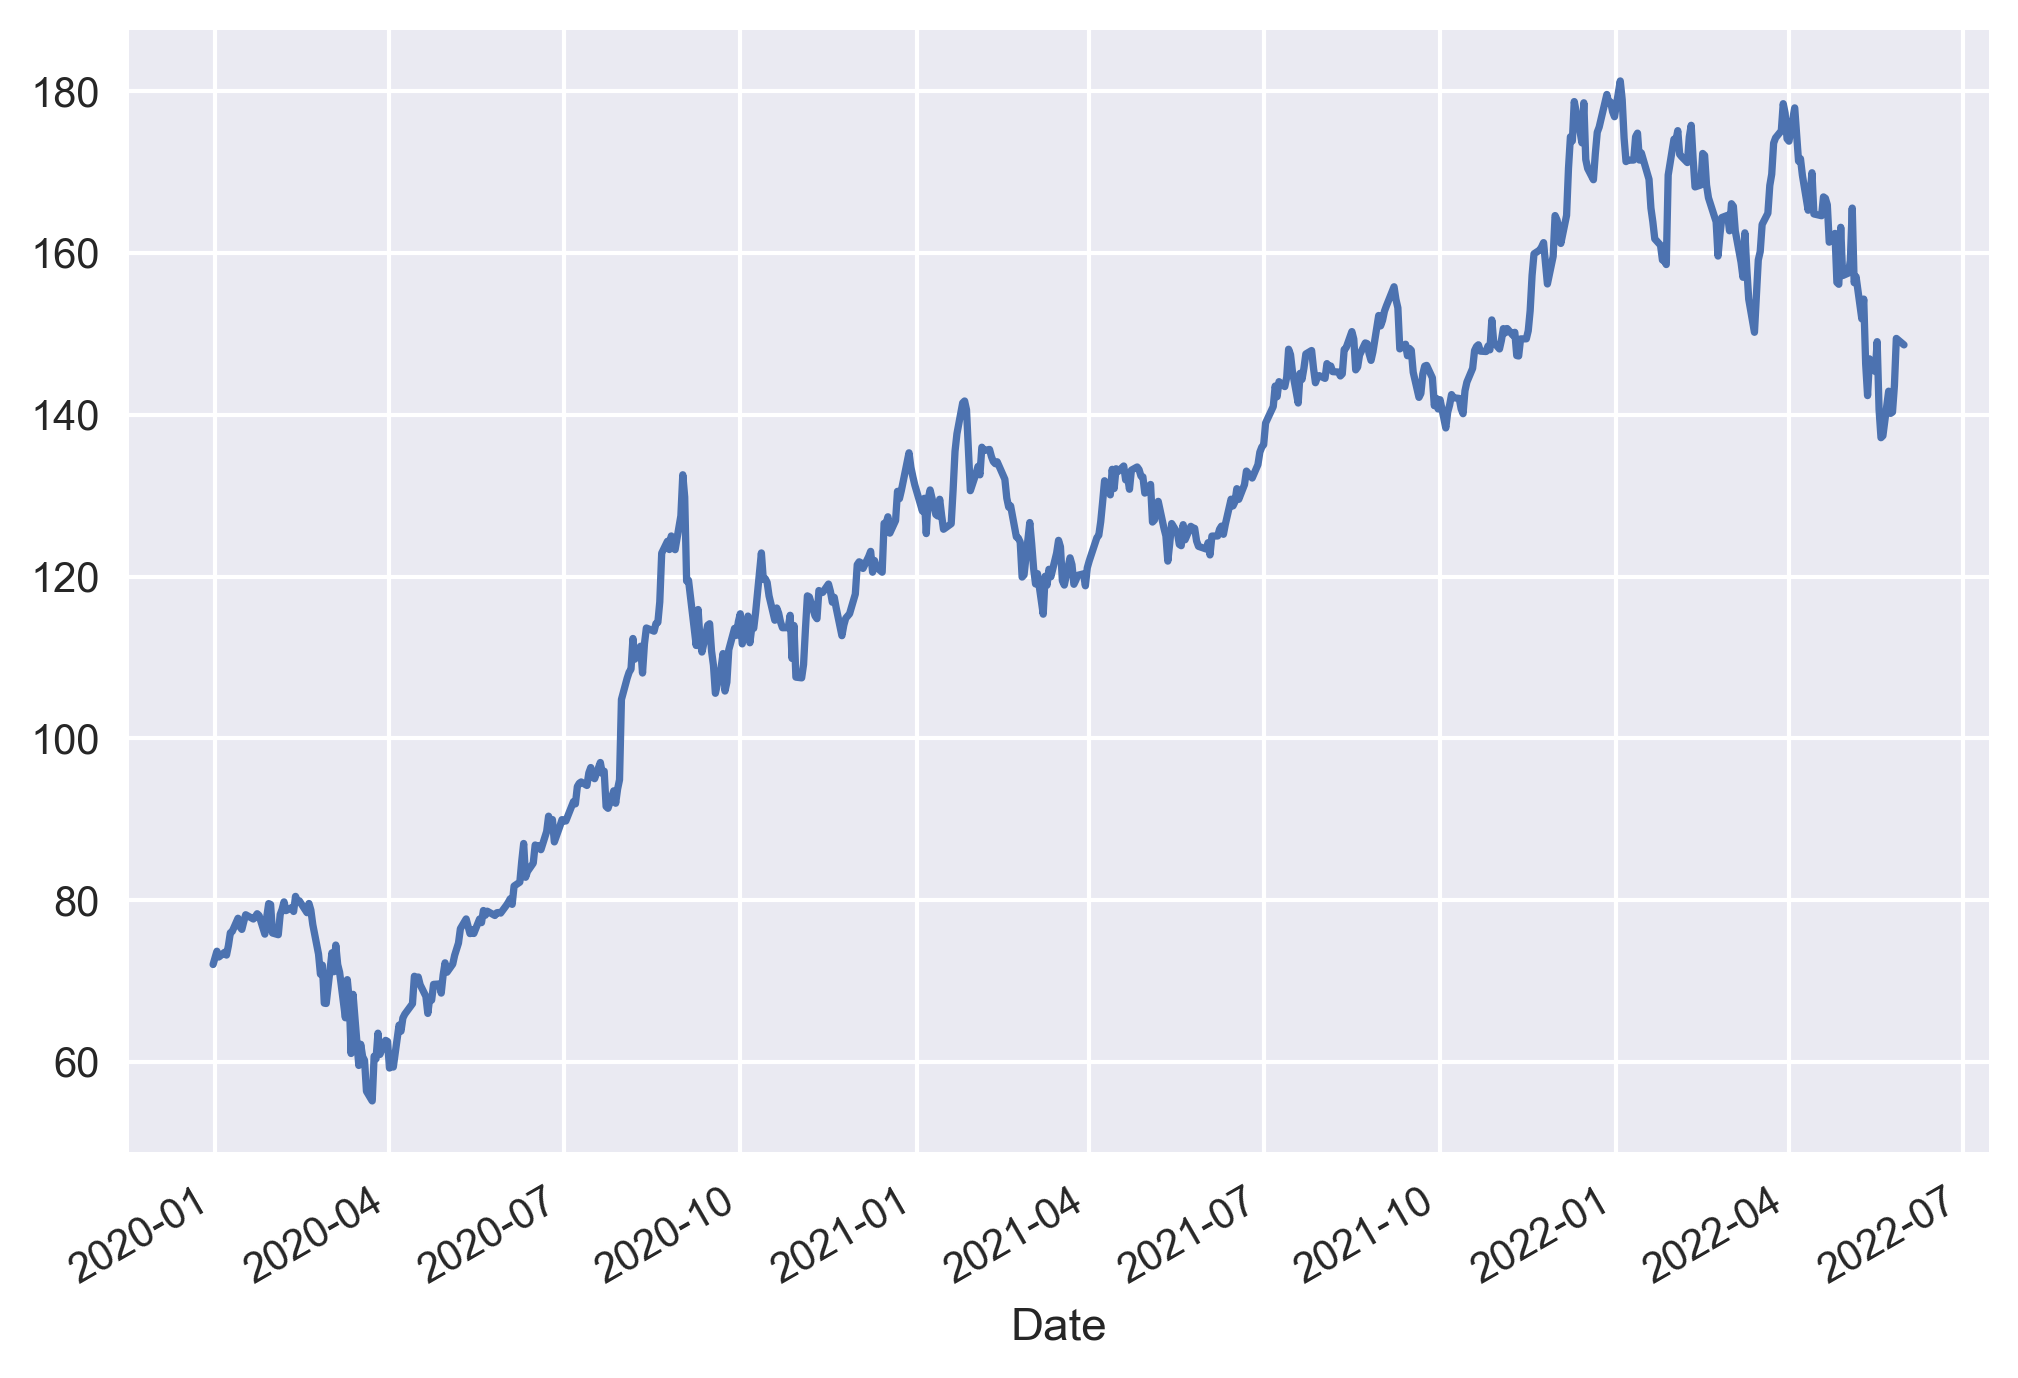

In [3]:
# Get the data for the stock AAPL
data = yf.download('AAPL','2020-01-01','2022-06-01')
# Plot the close price of the AAPL
data['Adj Close'].plot()
plt.show()

In [4]:
import pandas as pd
tickers_list = ['AAPL', 'WMT', 'IBM', 'MU', 'BA', 'AXP']

# Import pandas
data = pd.DataFrame(columns=tickers_list)

# Fetch the data

for ticker in tickers_list:
    data[ticker] = yf.download(ticker,'2020-01-01','2022-08-01')['Adj Close']

# Print first 5 rows of the data
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


AAPL         WMT         IBM         MU          BA  \
Date                                                                   
2019-12-31  72.039871  113.705383  111.766258  53.357246  323.833313   
2020-01-02  73.683578  113.801064  112.916924  54.954594  331.348572   
2020-01-03  72.967216  112.796440  112.016411  54.101349  330.791901   
2020-01-06  73.548630  112.566795  111.816292  53.148903  331.766083   
2020-01-07  73.202736  111.523895  111.891327  57.811958  335.285156   

                   AXP  
Date                    
2019-12-31  119.349220  
2020-01-02  121.071251  
2020-01-03  119.868706  
2020-01-06  119.349213  
2020-01-07  118.723900

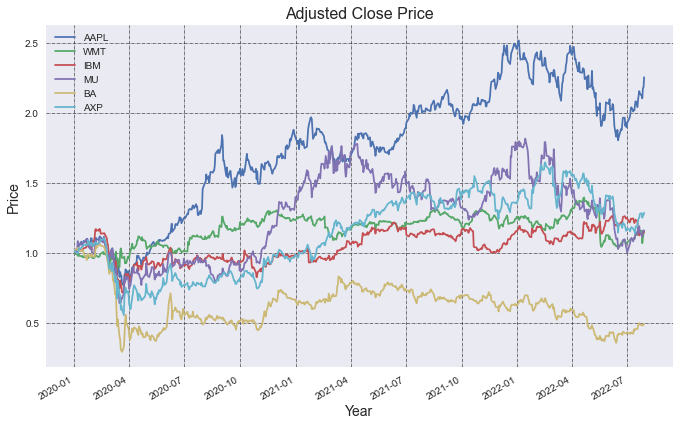

In [14]:
((data.pct_change()+1).cumprod()).plot(figsize=(10, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Adjusted Close Price", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

We could try to build an investment portfolio, in this case we would need to identify stocks that are prone to growth and with low correlations among themselves, in order to diversify assets

<AxesSubplot:>

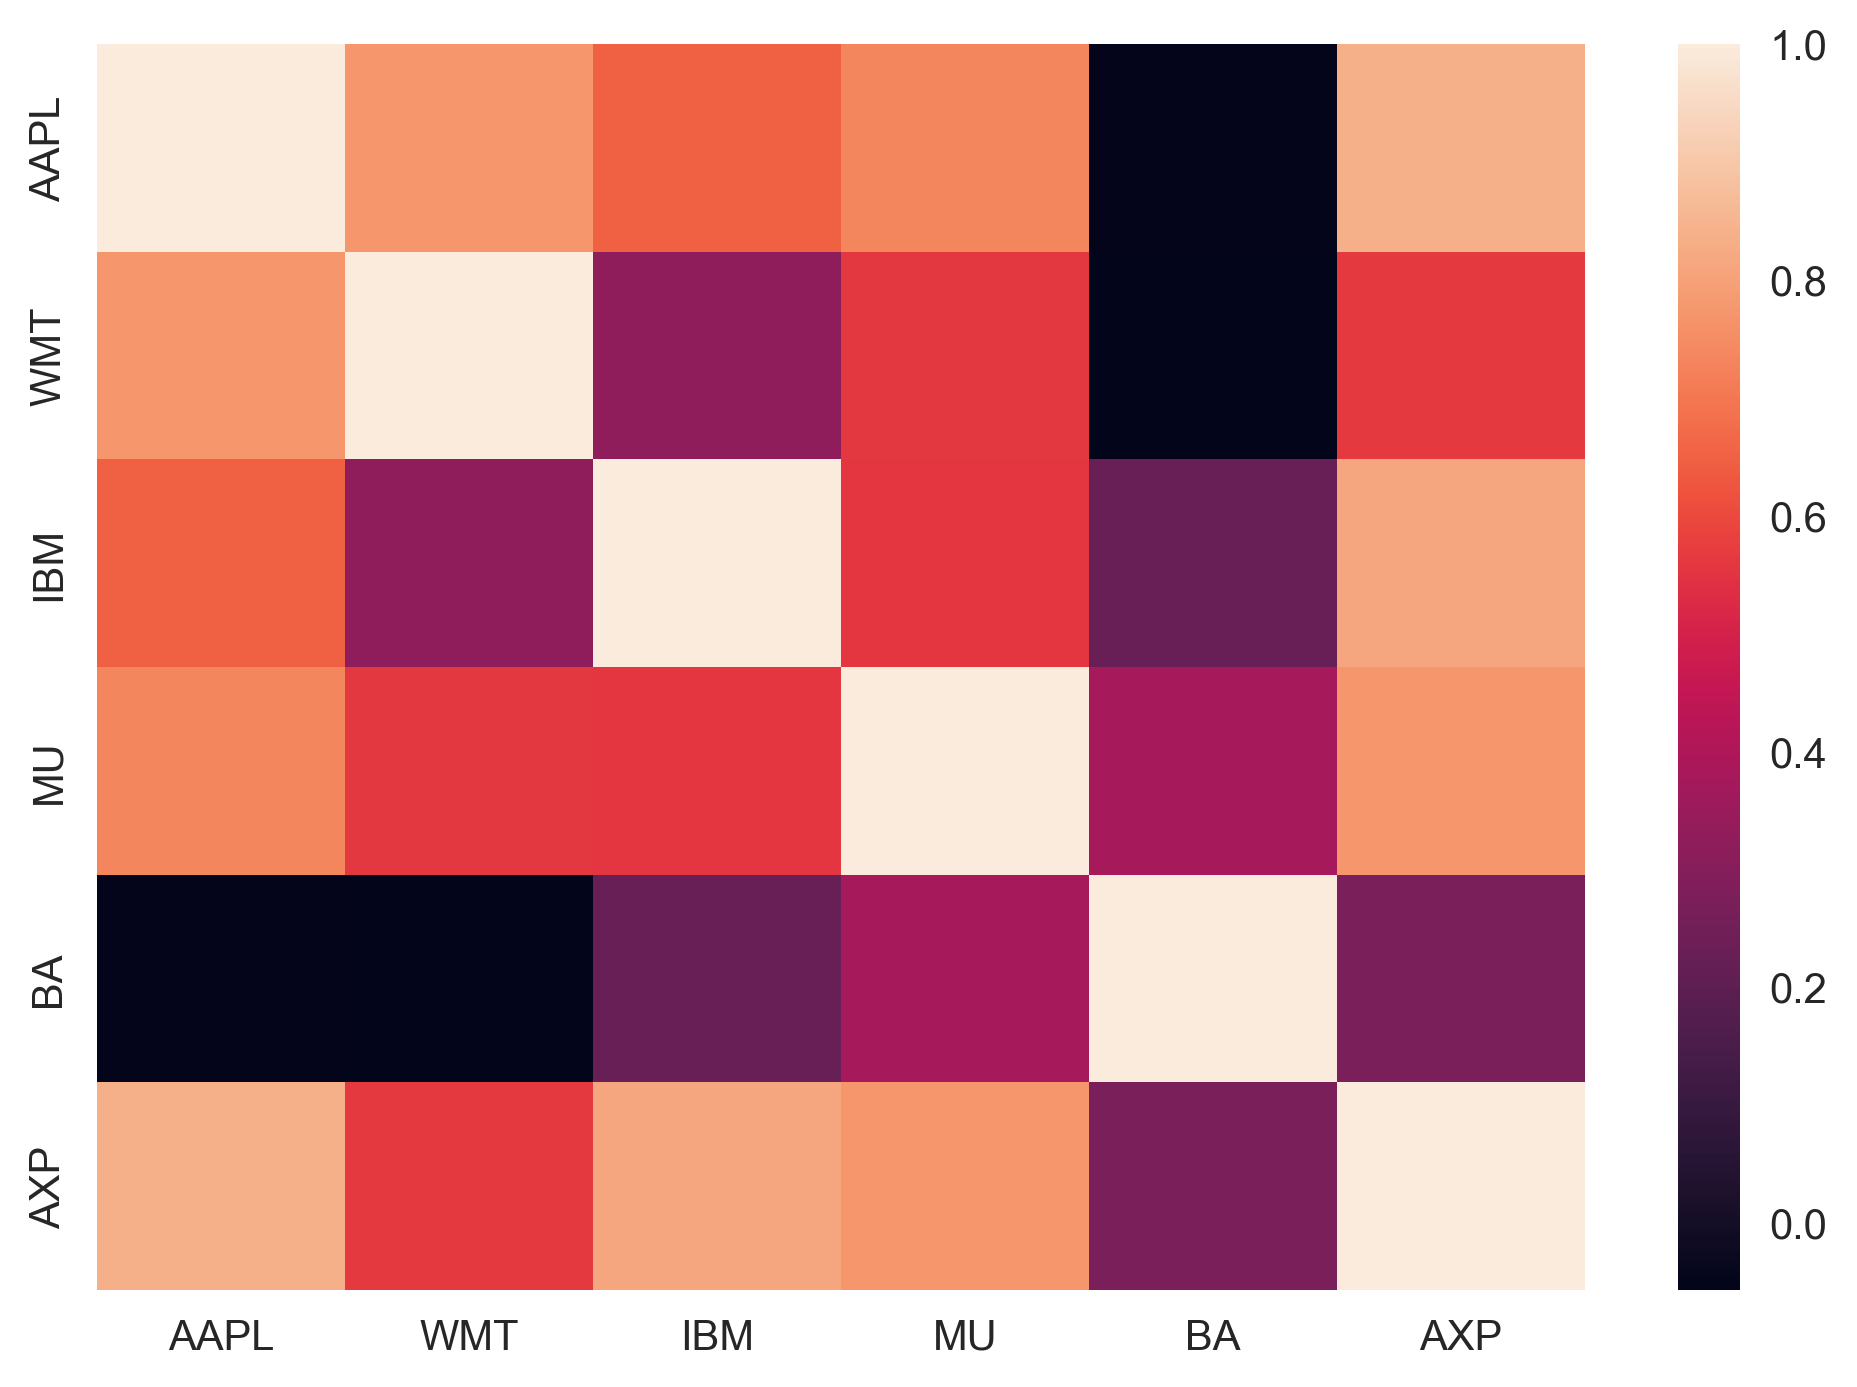

In [5]:
plt.style.use('seaborn')

plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

correlation = data.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns)

In [6]:
abs(correlation['AAPL'])

AAPL    1.000000
WMT     0.769323
IBM     0.647233
MU      0.733280
BA      0.052636
AXP     0.838294
Name: AAPL, dtype: float64

Now we will focus on one company to try to forecast and determine the prospects of investments

In [7]:
df_yahoo = yf.download('AAPL', 
                       start='2018-01-01', 
                       end='2022-06-01',
                       progress=False)

In [8]:
df_yahoo

Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-02   42.540001   43.075001   42.314999   43.064999   41.018433   
2018-01-03   43.132500   43.637501   42.990002   43.057499   41.011276   
2018-01-04   43.134998   43.367500   43.020000   43.257500   41.201778   
2018-01-05   43.360001   43.842499   43.262501   43.750000   41.670876   
2018-01-08   43.587502   43.902500   43.482498   43.587502   41.516098   
...                ...         ...         ...         ...         ...   
2022-05-24  140.809998  141.970001  137.330002  140.360001  140.165298   
2022-05-25  138.429993  141.789993  138.339996  140.520004  140.325089   
2022-05-26  137.389999  144.339996  137.139999  143.779999  143.580551   
2022-05-27  145.389999  149.679993  145.259995  149.639999  149.432434   
2022-05-31  149.070007  150.660004  146.839996  148.839996  148.633545   

               Volume  
Date                   
2018-01-02  102223600  
2018-01-03  118071600  
2018-01-04   89738400  
2018-01-05   94640000  
2018-01-08   82271200  
...               ...  
2022-05-24  104132700  
2022-05-25   92482700  
2022-05-26   90601500  
2022-05-27   90978500  
2022-05-31  103718400  

[1111 rows x 6 columns]

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

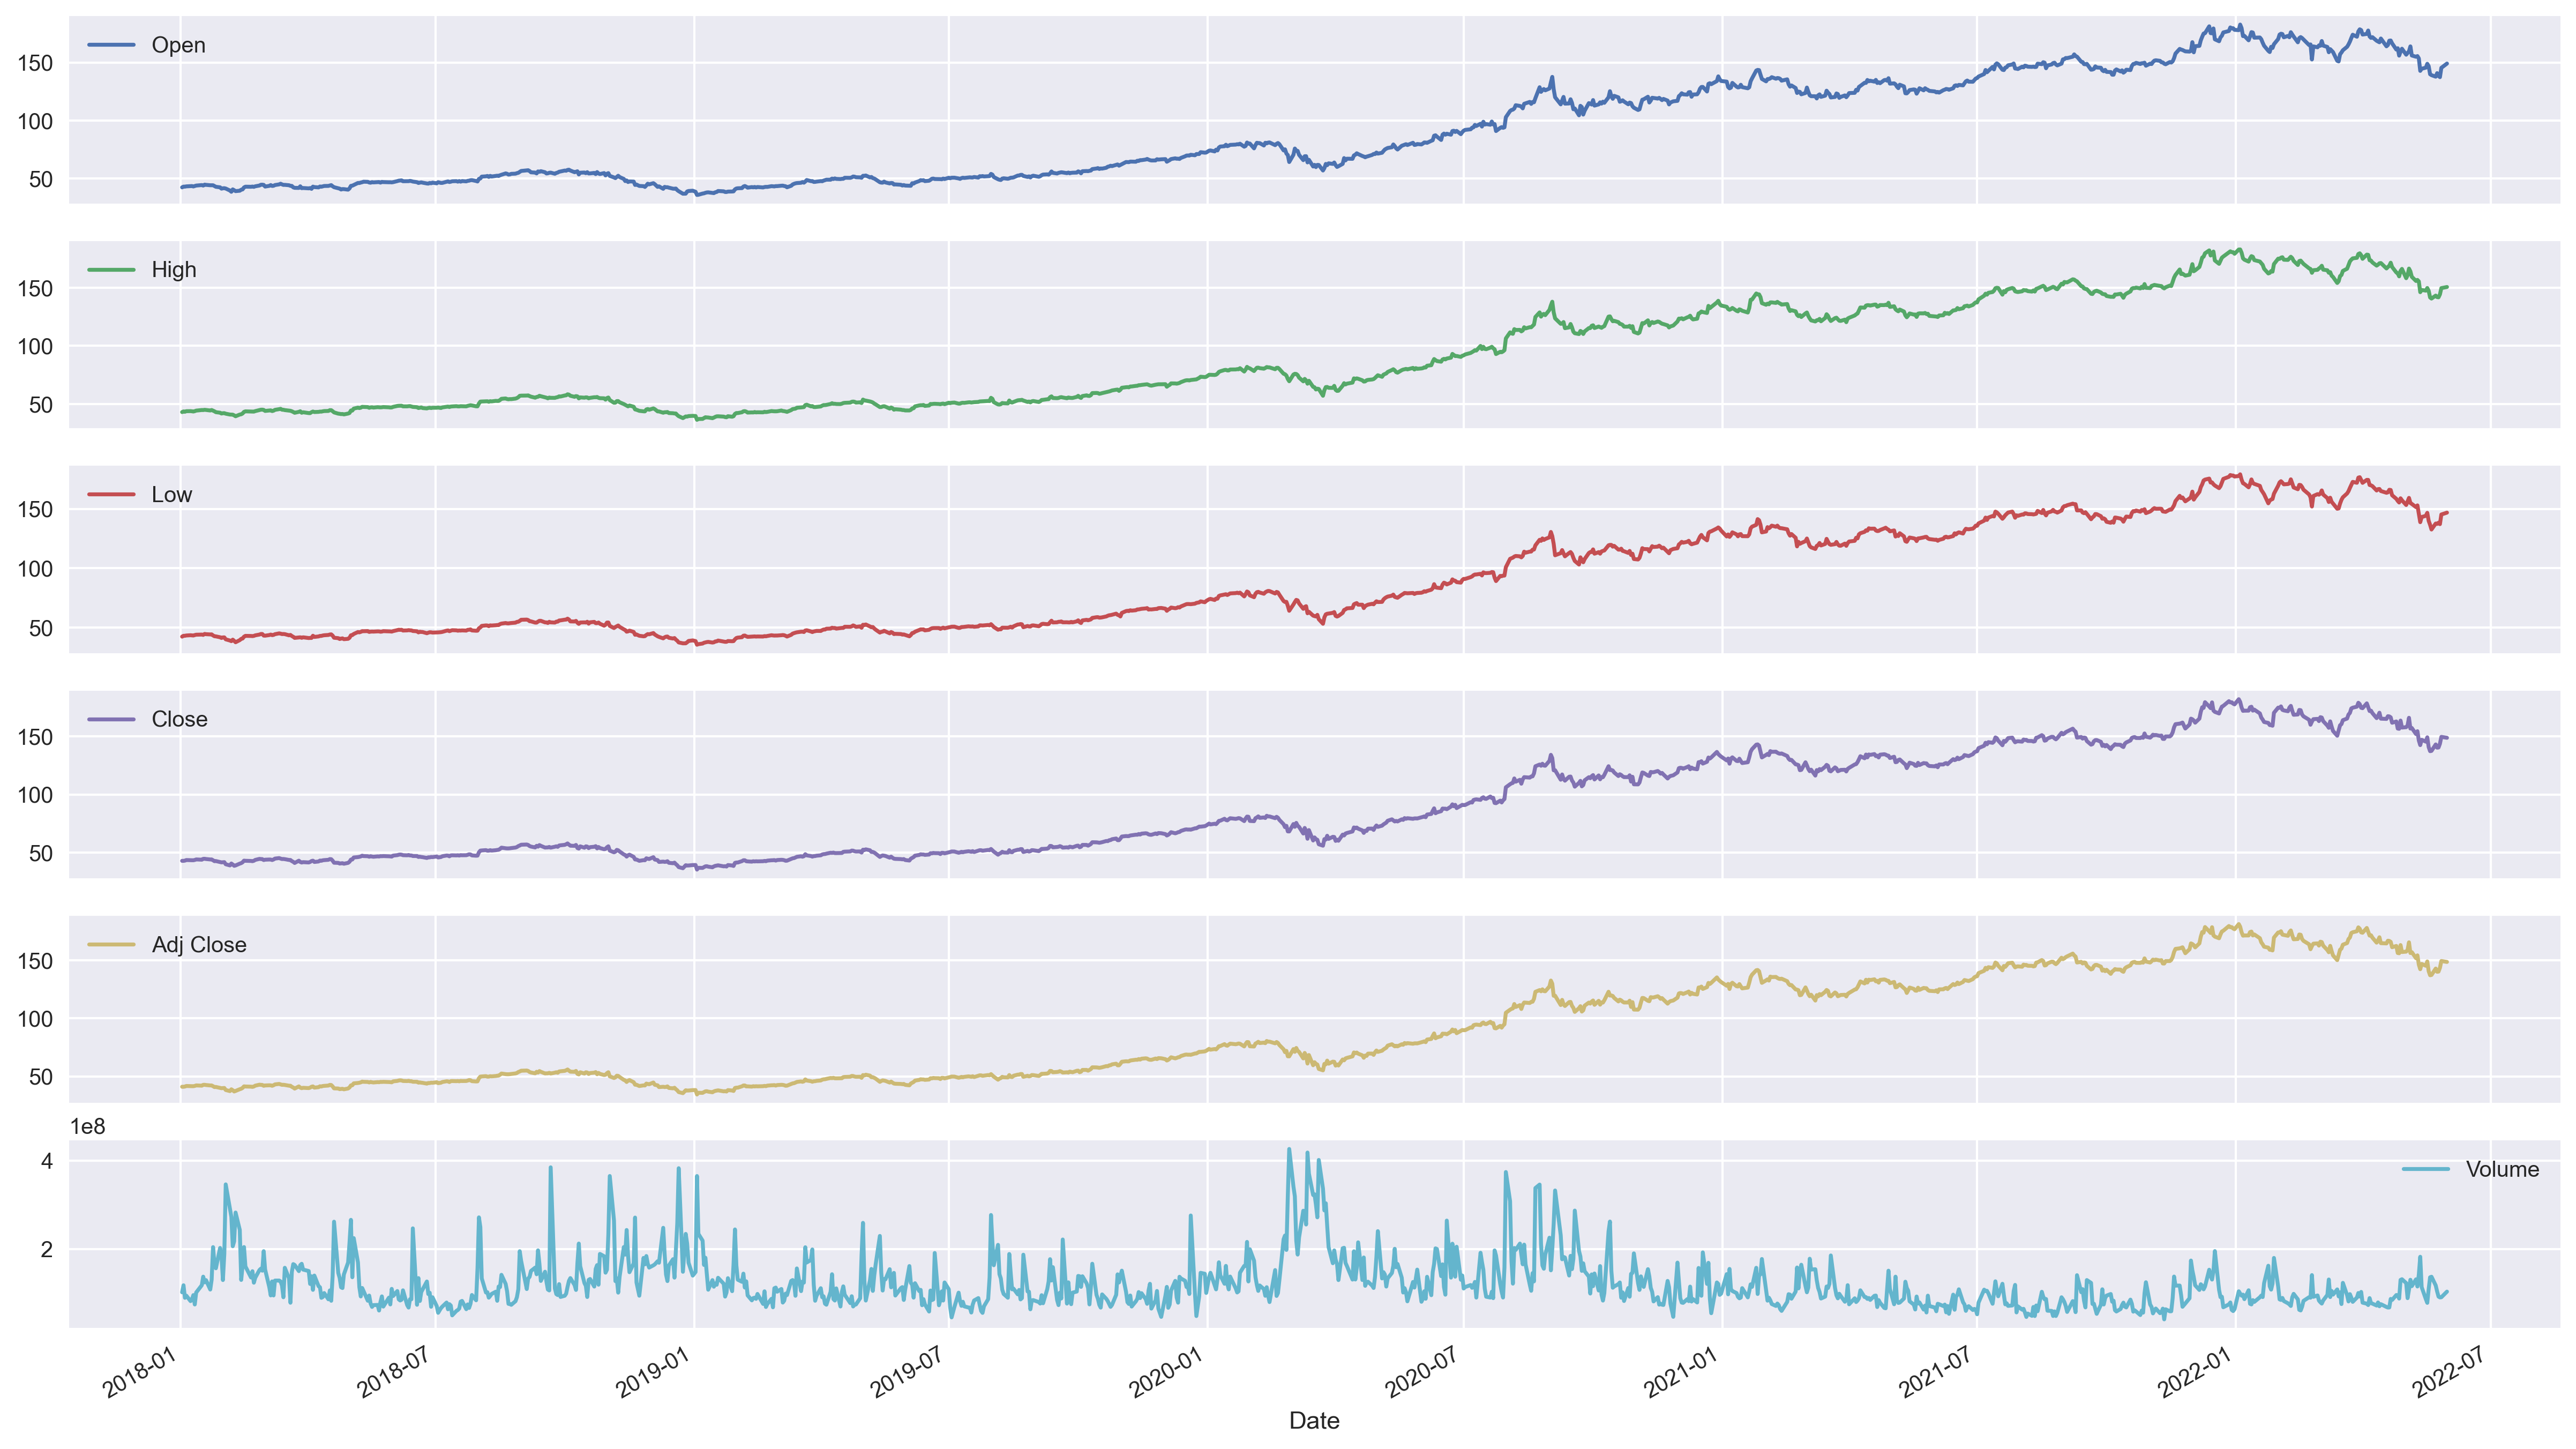

In [9]:
df_yahoo.plot(subplots=True, figsize=(20,12))

<BarContainer object of 53 artists>

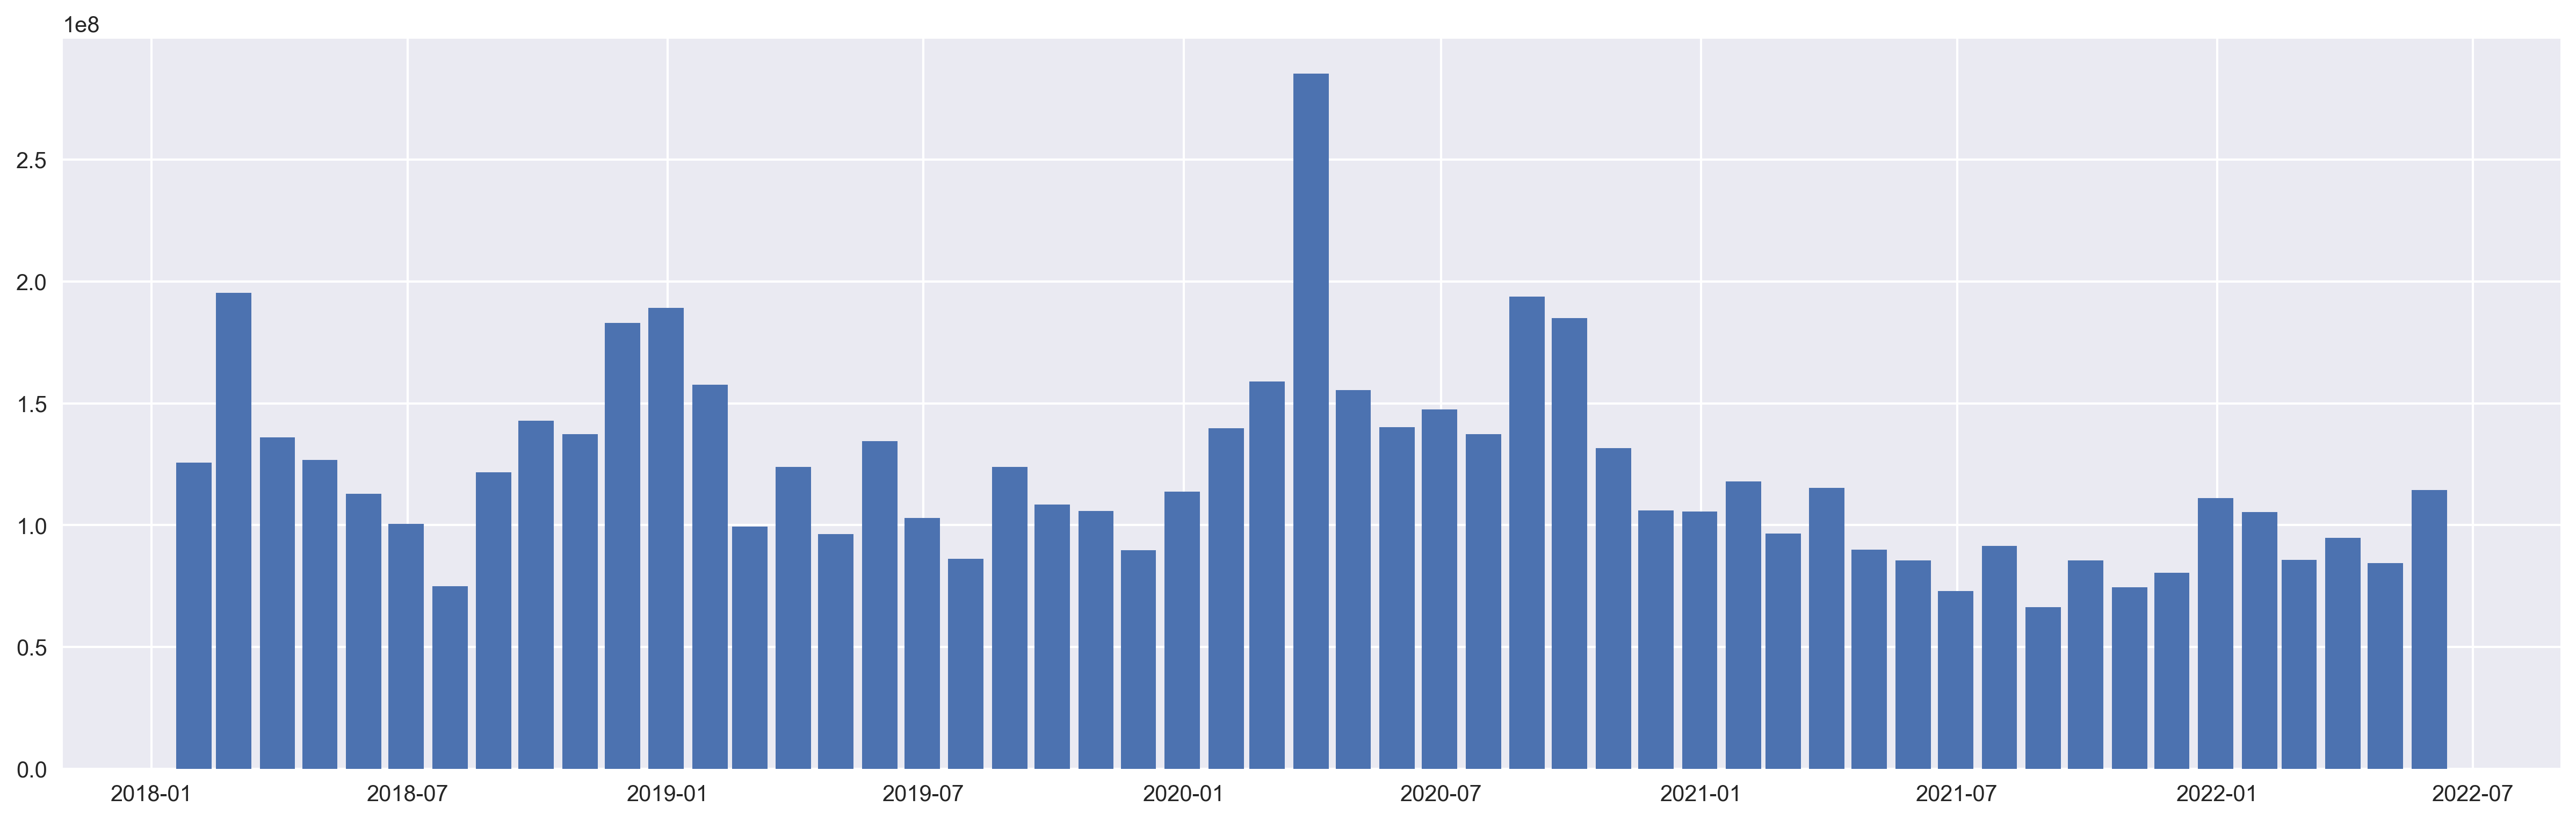

In [10]:
df_month = df_yahoo.resample("M").mean()
fig, ax = plt.subplots(figsize=(20, 6))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax.bar(
    df_month['2018':].index, 
    df_month.loc['2018':, "Volume"], 
    width=25, align='center')

In [14]:
df_yahoo['Adj Close']

Date
2018-01-02     41.018433
2018-01-03     41.011276
2018-01-04     41.201778
2018-01-05     41.670876
2018-01-08     41.516098
                 ...    
2022-05-24    140.165298
2022-05-25    140.325089
2022-05-26    143.580551
2022-05-27    149.432434
2022-05-31    148.633545
Name: Adj Close, Length: 1111, dtype: float64

<AxesSubplot:xlabel='Date'>

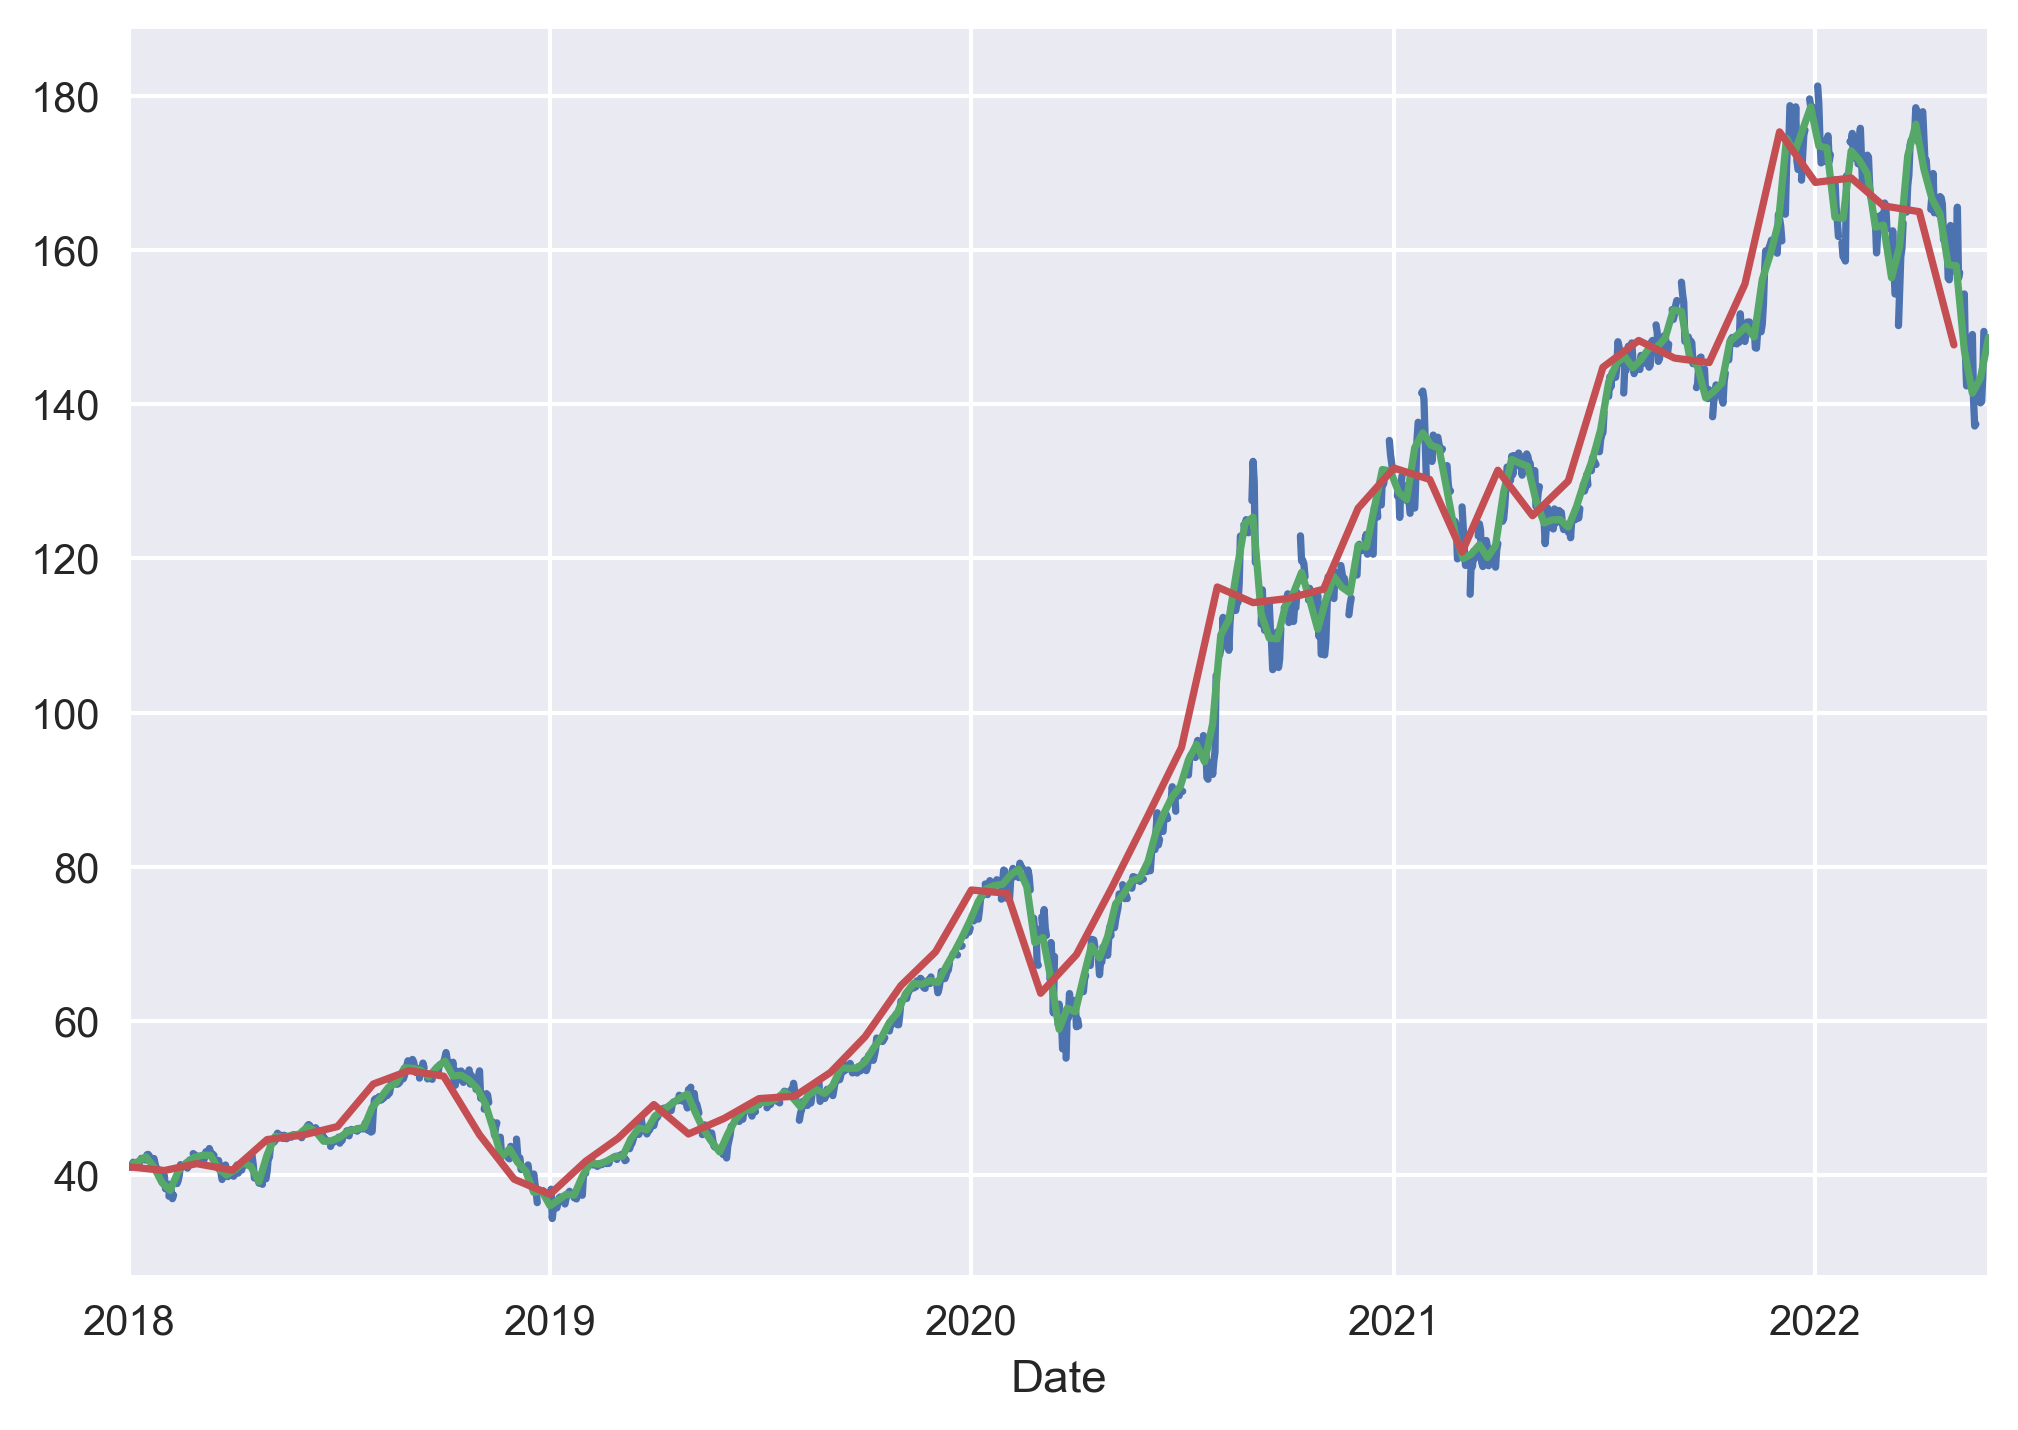

In [18]:
data=df_yahoo['Adj Close']
data = data.resample('1D').mean()
data.plot()
data = data.resample('7D').mean()
data.plot()
data = data.resample('1M').mean()
data.plot()

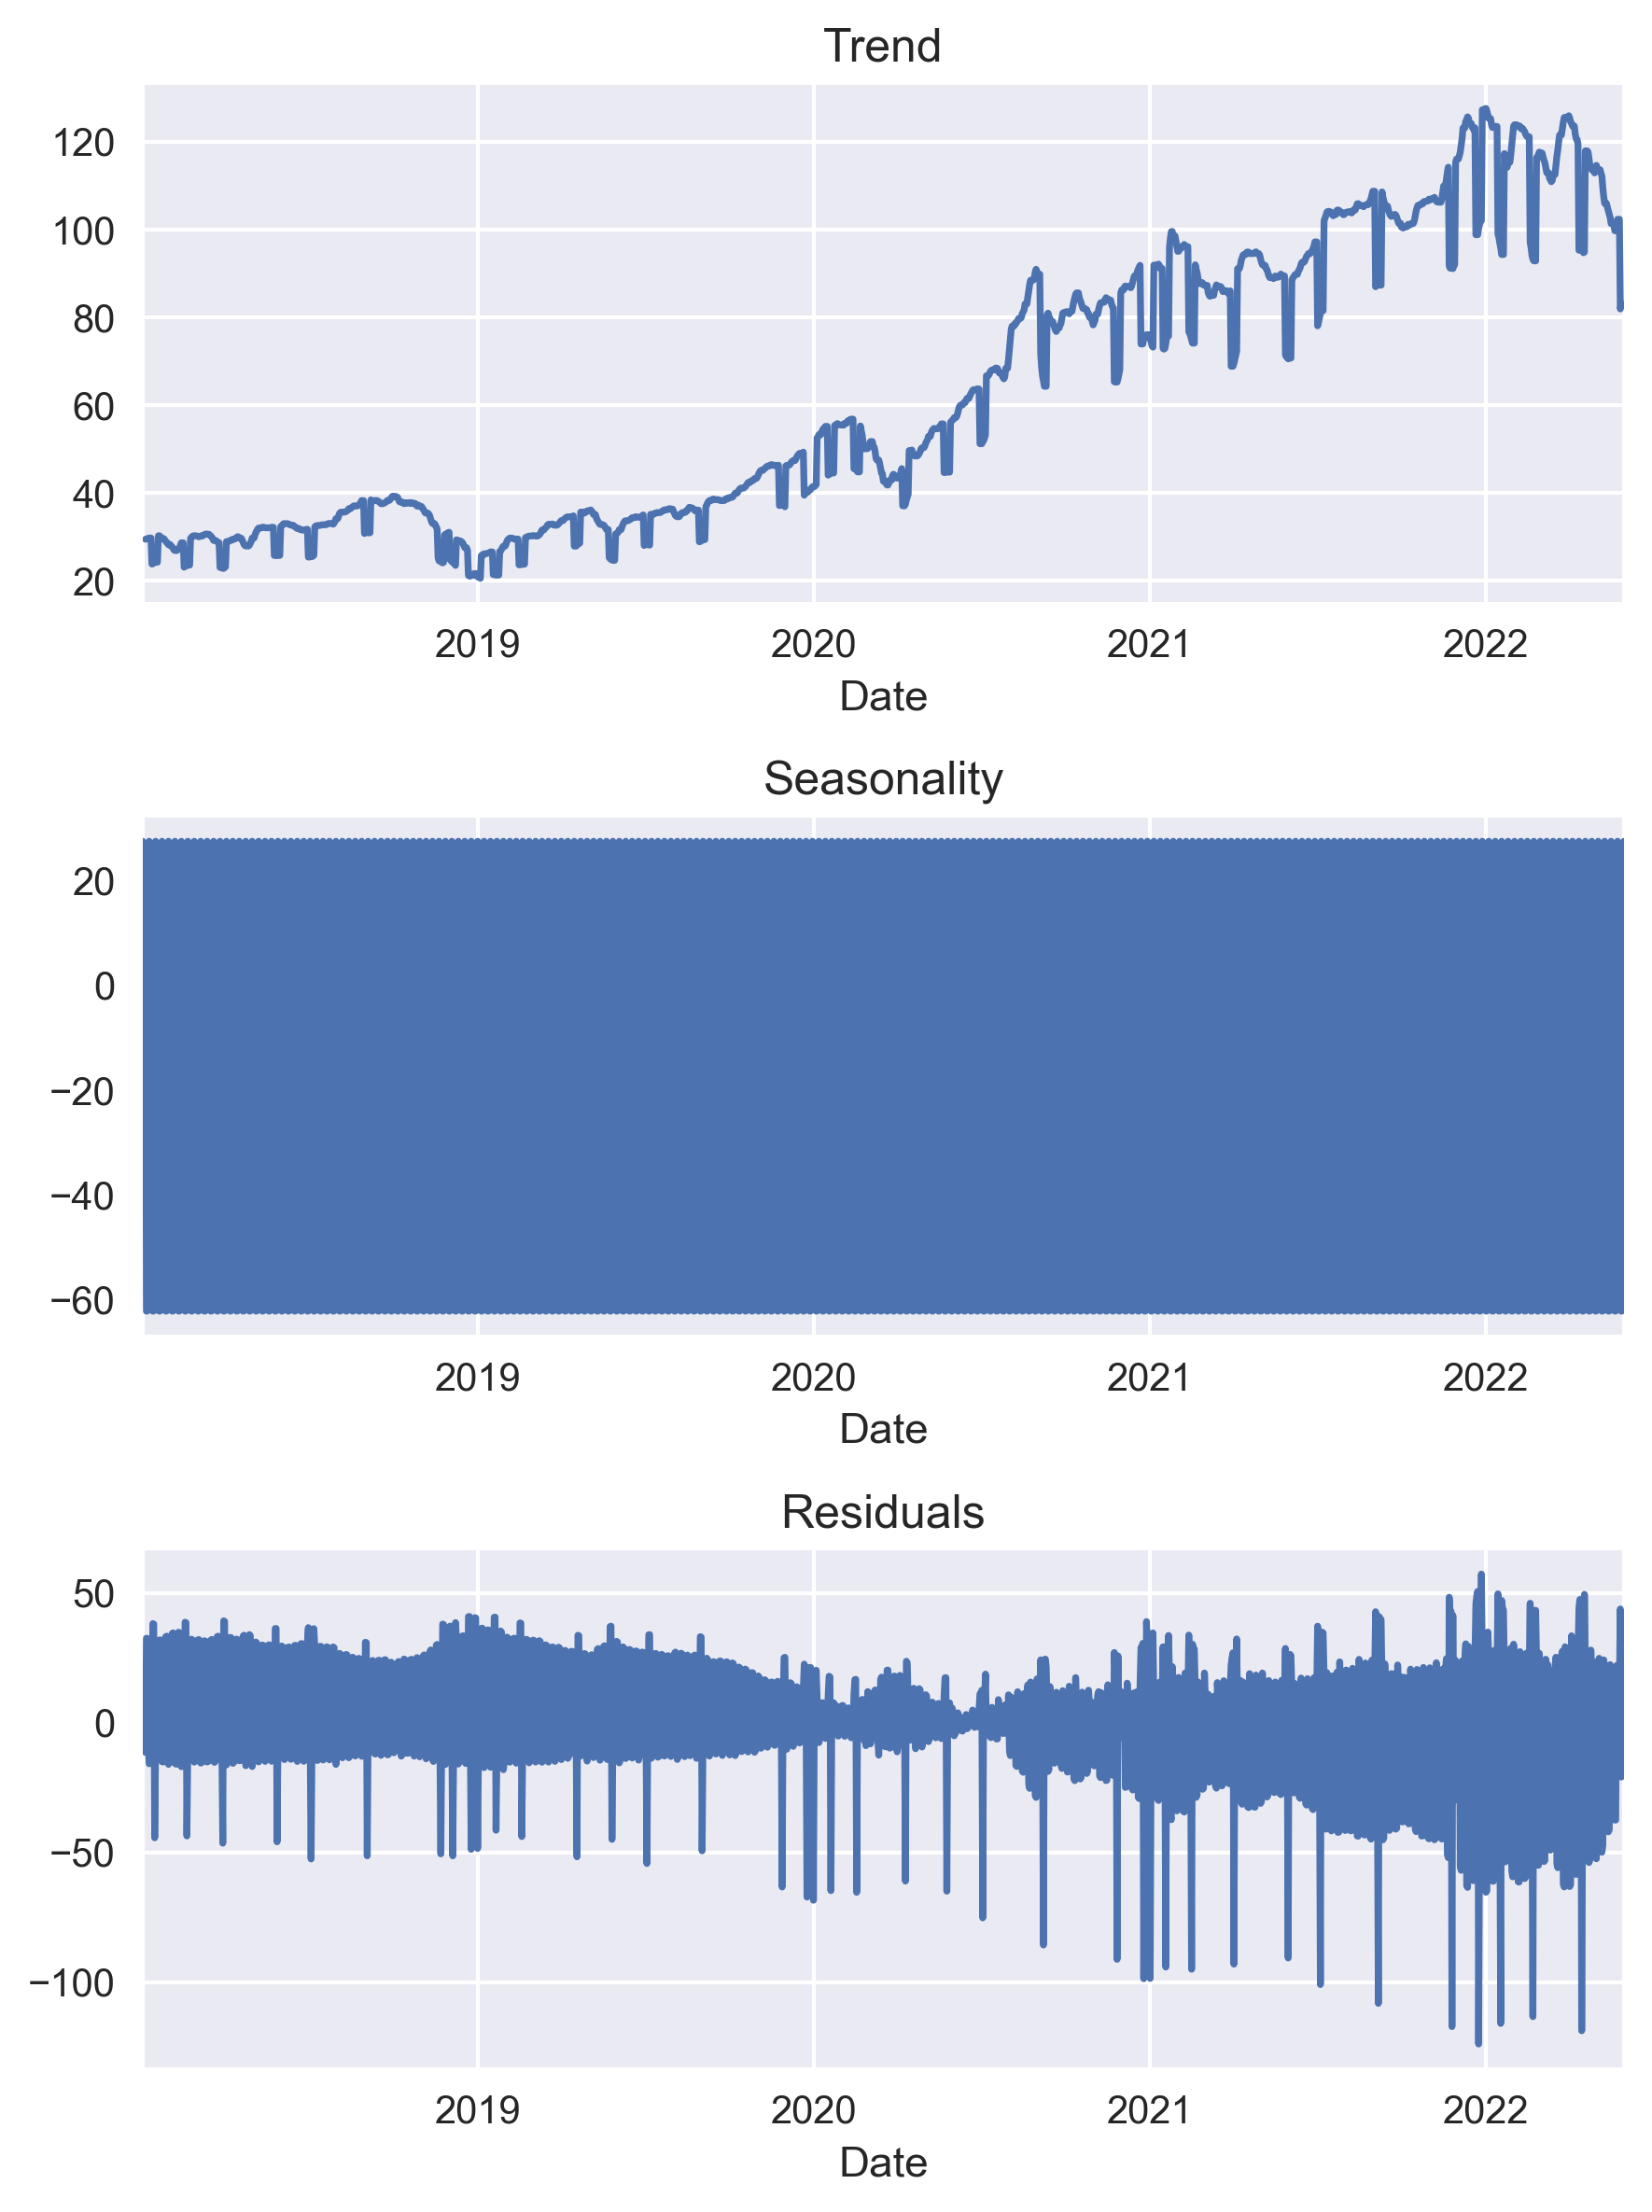

In [31]:
data=df_yahoo['Adj Close']
data = data.resample('1D').sum()
decomposed = seasonal_decompose(data)  
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='Date'>

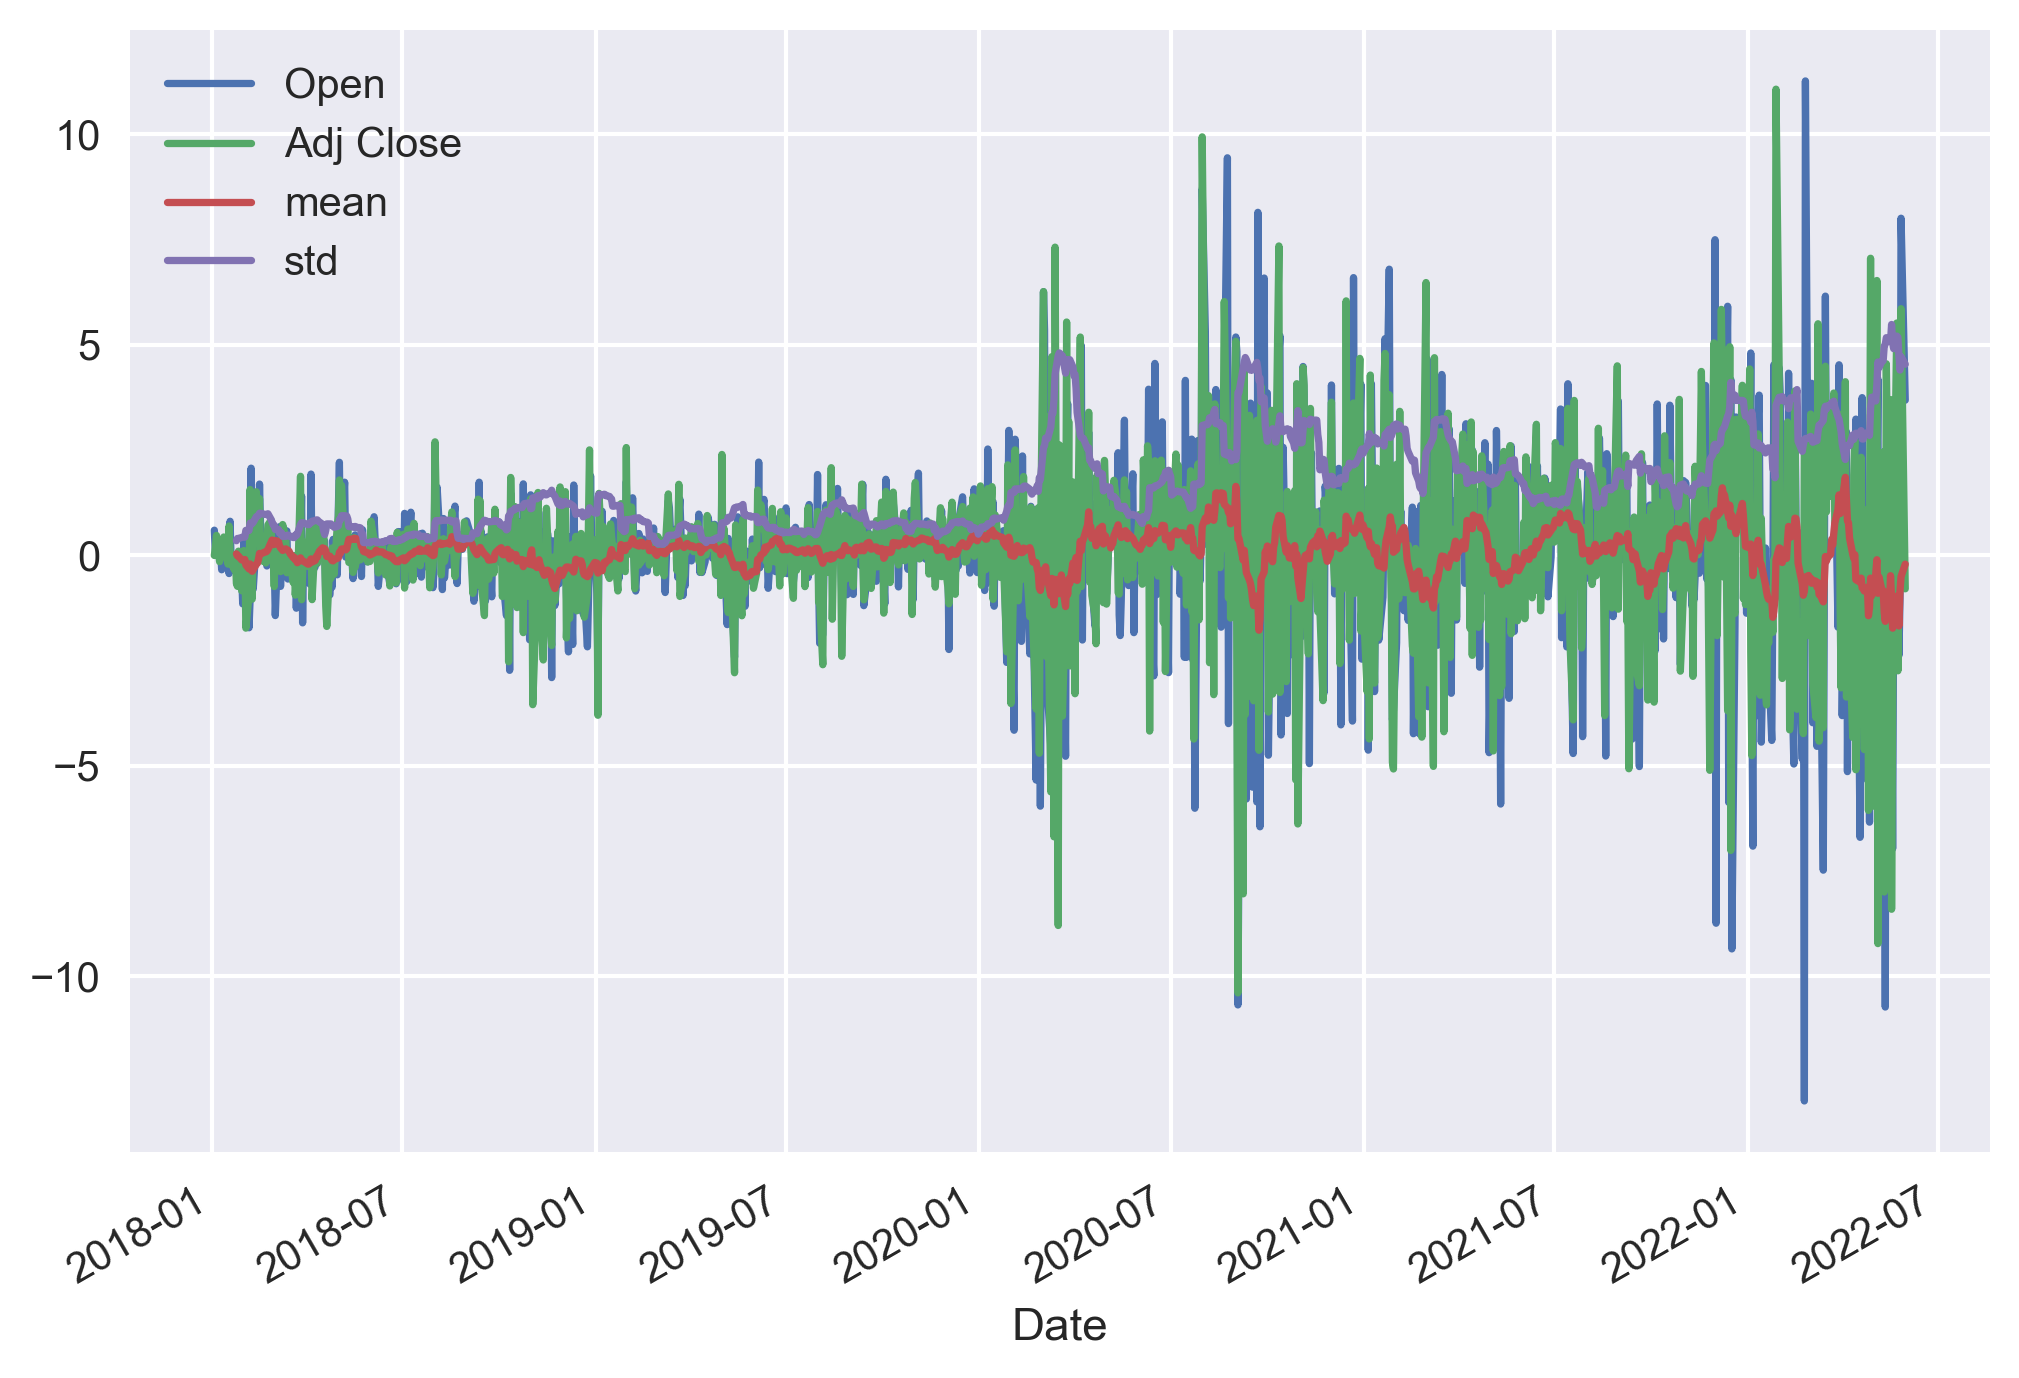

In [36]:
data=df_yahoo[['Open','Adj Close']]
data=data-data.shift()# < напишите код здесь >
data['mean'] = data['Adj Close'].rolling(15).mean()
data['std'] = data['Adj Close'].rolling(15).std()
data.plot()

In [48]:
data = pd.DataFrame(df_yahoo['Adj Close']).dropna()
window = 7
data['min'] = data['Adj Close'].rolling(window=window).min()
data['mean'] = data['Adj Close'].rolling(window=window).mean() 
data['std'] = data['Adj Close'].rolling(window=window).std()  
data['median'] = data['Adj Close'].rolling(window=window).median() 
data['max'] = data['Adj Close'].rolling(window=window).max()  
data['ewma'] = data['Adj Close'].ewm(halflife=0.5, min_periods=window).mean()  
data.dropna().head()

Adj Close        min       mean       std     median        max  \
Date                                                                          
2018-01-10  41.501812  41.011276  41.347373  0.266527  41.501812  41.670876   
2018-01-11  41.737537  41.011276  41.450103  0.257025  41.511341  41.737537   
2018-01-12  42.168541  41.201778  41.615426  0.296826  41.516098  42.168541   
2018-01-16  41.954239  41.501812  41.722921  0.255421  41.670876  42.168541   
2018-01-17  42.647163  41.501812  41.862390  0.429494  41.737537  42.647163   

                 ewma  
Date                   
2018-01-10  41.504923  
2018-01-11  41.679386  
2018-01-12  42.046254  
2018-01-16  41.977243  
2018-01-17  42.479683

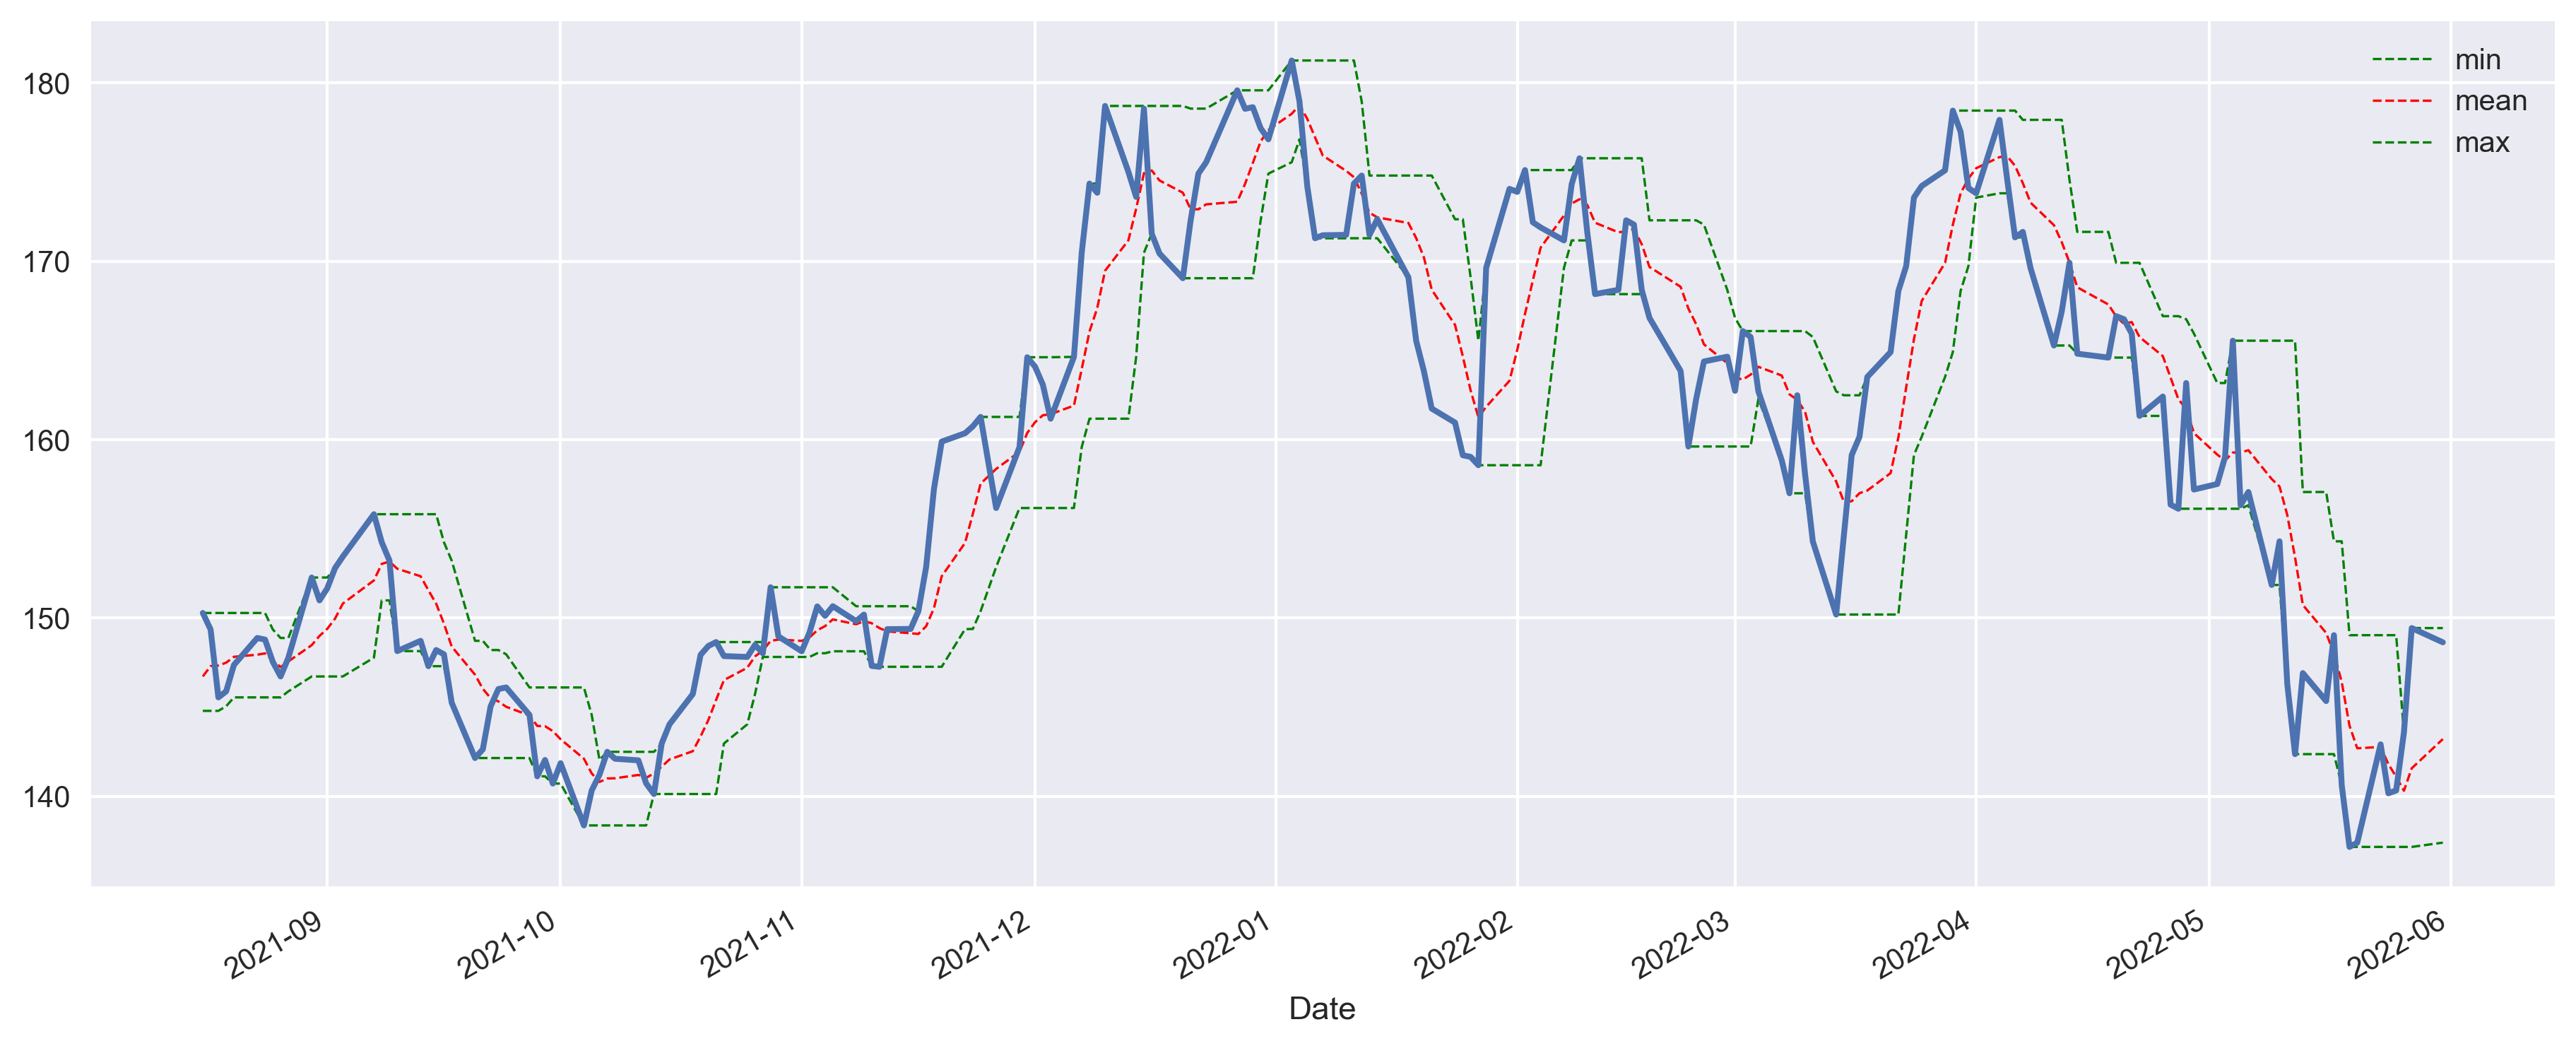

In [49]:
ax = data[['min', 'mean', 'max']].iloc[-200:].plot(
    figsize=(15, 6), style=['g--', 'r--', 'g--'], lw=0.8)  
data['Adj Close'].iloc[-200:].plot(ax=ax, lw=2.0);  

In [39]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [46]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_yahoo['Adj Close'], order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:13395.901074728445
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:11840.177858376755
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:7241.459205783564
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:7170.068973153646
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:7231.949345123647
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:7226.97745642351
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:7176.517484707276
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7169.672296983004
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:11885.842158994445
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:10377.555714556087
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6346.640336154884
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6281.36655590101
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6348.681499622942
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6327.471259619146
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6293.936881471063
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:6282.735836755154
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:4707.819890938273
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4670.539793801432
ARIMA(0,

In [94]:
data['Adj Close']

Date
2018-01-02     41.018433
2018-01-03     41.011276
2018-01-04     41.201778
2018-01-05     41.670876
2018-01-08     41.516098
                 ...    
2022-05-24    140.165298
2022-05-25    140.325089
2022-05-26    143.580551
2022-05-27    149.432434
2022-05-31    148.633545
Name: Adj Close, Length: 1111, dtype: float64

In [95]:
mod = sm.tsa.statespace.SARIMAX(data[['Adj Close']],
order=(1, 1, 1),
seasonal_order=(1, 1, 1, 12),
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0816      0.275      0.296      0.767      -0.458       0.621
ma.L1         -0.1496      0.275     -0.543      0.587      -0.689       0.390
ar.S.L12   -2.818e-05      0.024     -0.001      0.999      -0.047       0.047
ma.S.L12      -0.9812      0.011    -88.854      0.000      -1.003      -0.960
sigma2         4.1383      0.105     39.400      0.000       3.932       4.344


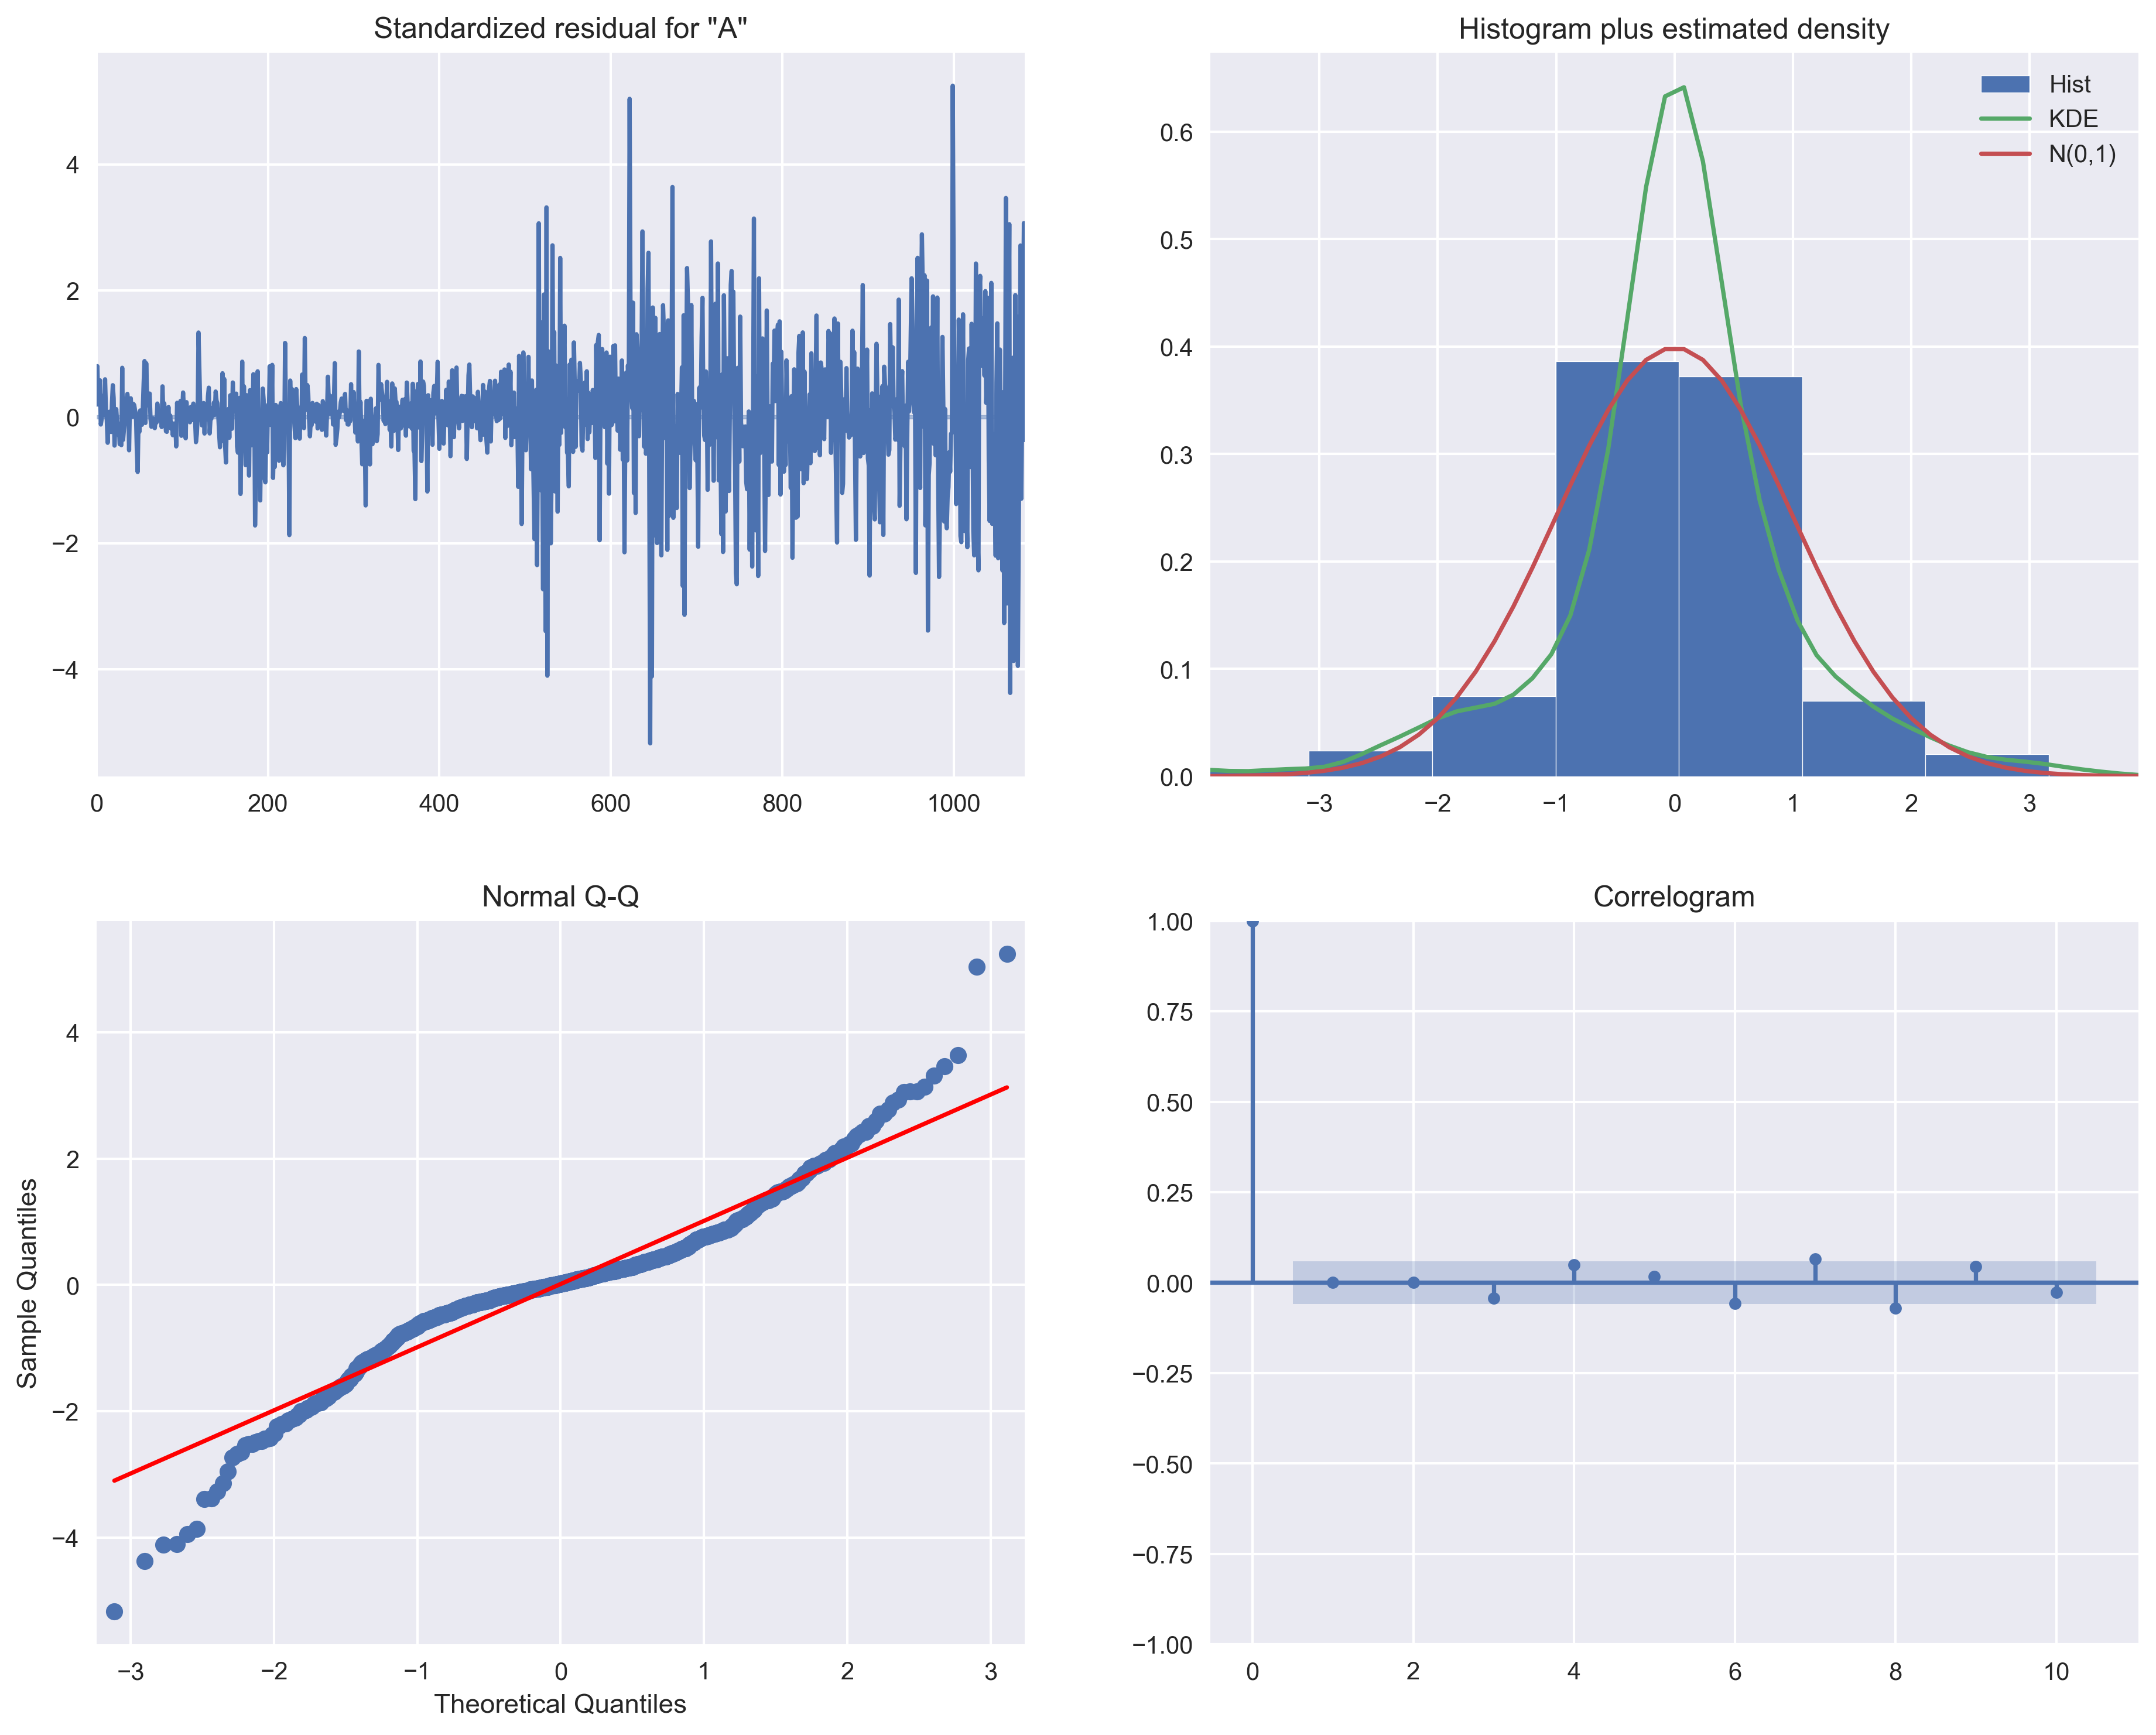

In [96]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [97]:
df = data.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)
df['simple_rtn'] = df.adj_close.pct_change()
df_rolling = df[['simple_rtn']].rolling(window=21) \
                               .agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

In [98]:
df_outliers = df.join(df_rolling)

In [99]:
def indentify_outliers(row, n_sigmas=3):
    '''
A function for determining outliers using the 3 sigma rule.
The row must contain the following columns/indexes: simple_rtn, average, std.

Parameters
----------
string : pd series.
The string of the pd data frame to which the function can be applied.
n_sigmas : number
of standard deviations above/below average - used to detect outliers

Is returning
-------
0/1 : int
An integer with 1 indicating an outlier and 0 otherwise.
    '''
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0

In [100]:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers, 
                                           axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, 
                           ['simple_rtn']]

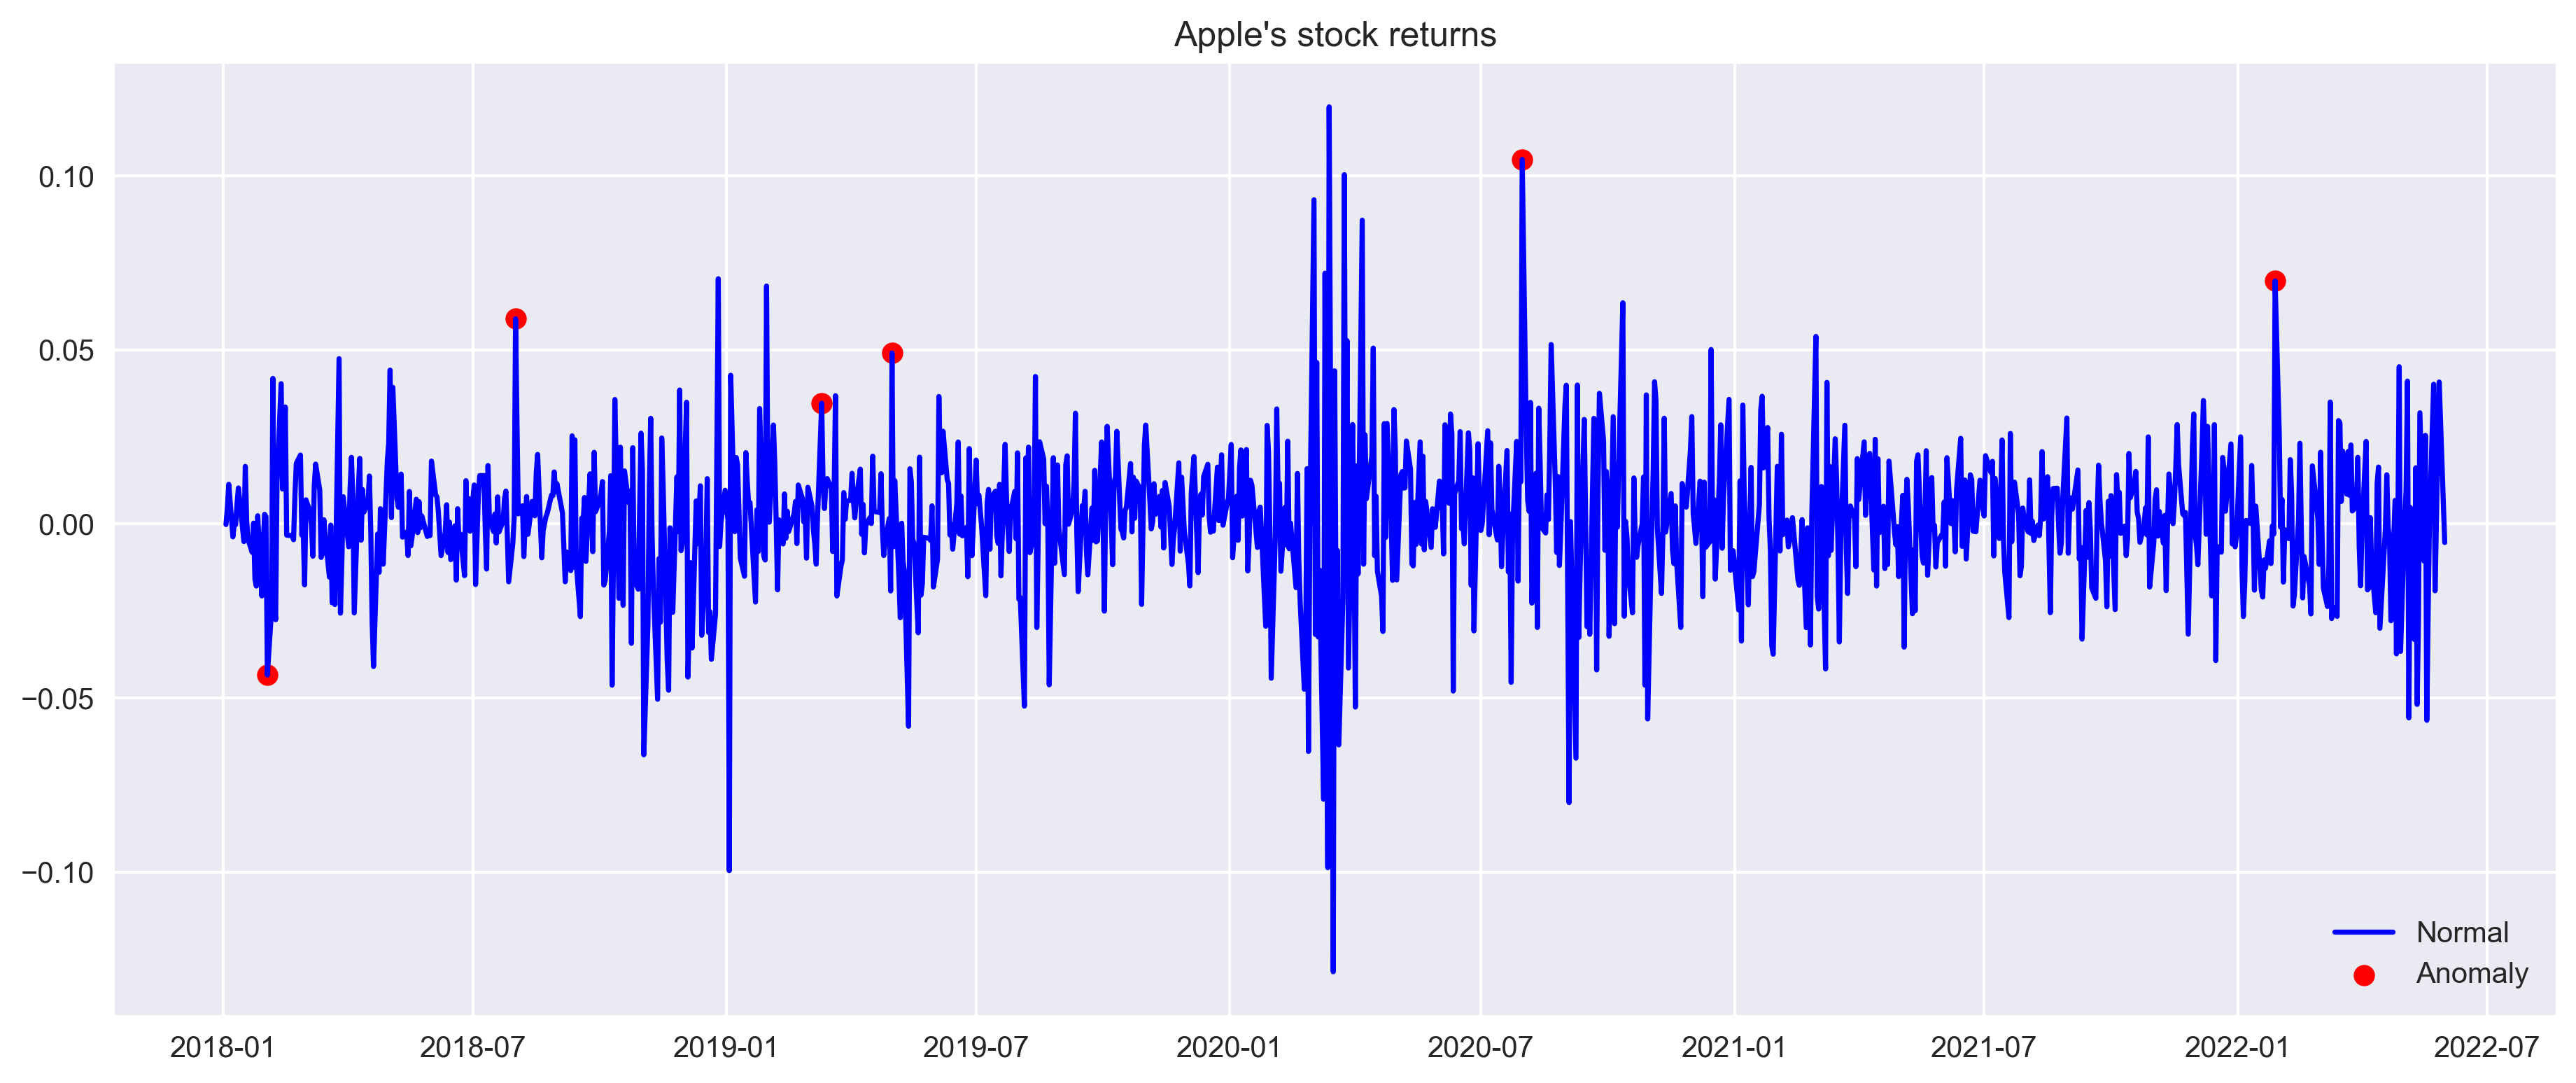

In [101]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df_outliers.index, df_outliers.simple_rtn, 
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, 
           color='red', label='Anomaly')
ax.set_title("Apple's stock returns")
ax.legend(loc='lower right')

plt.show()

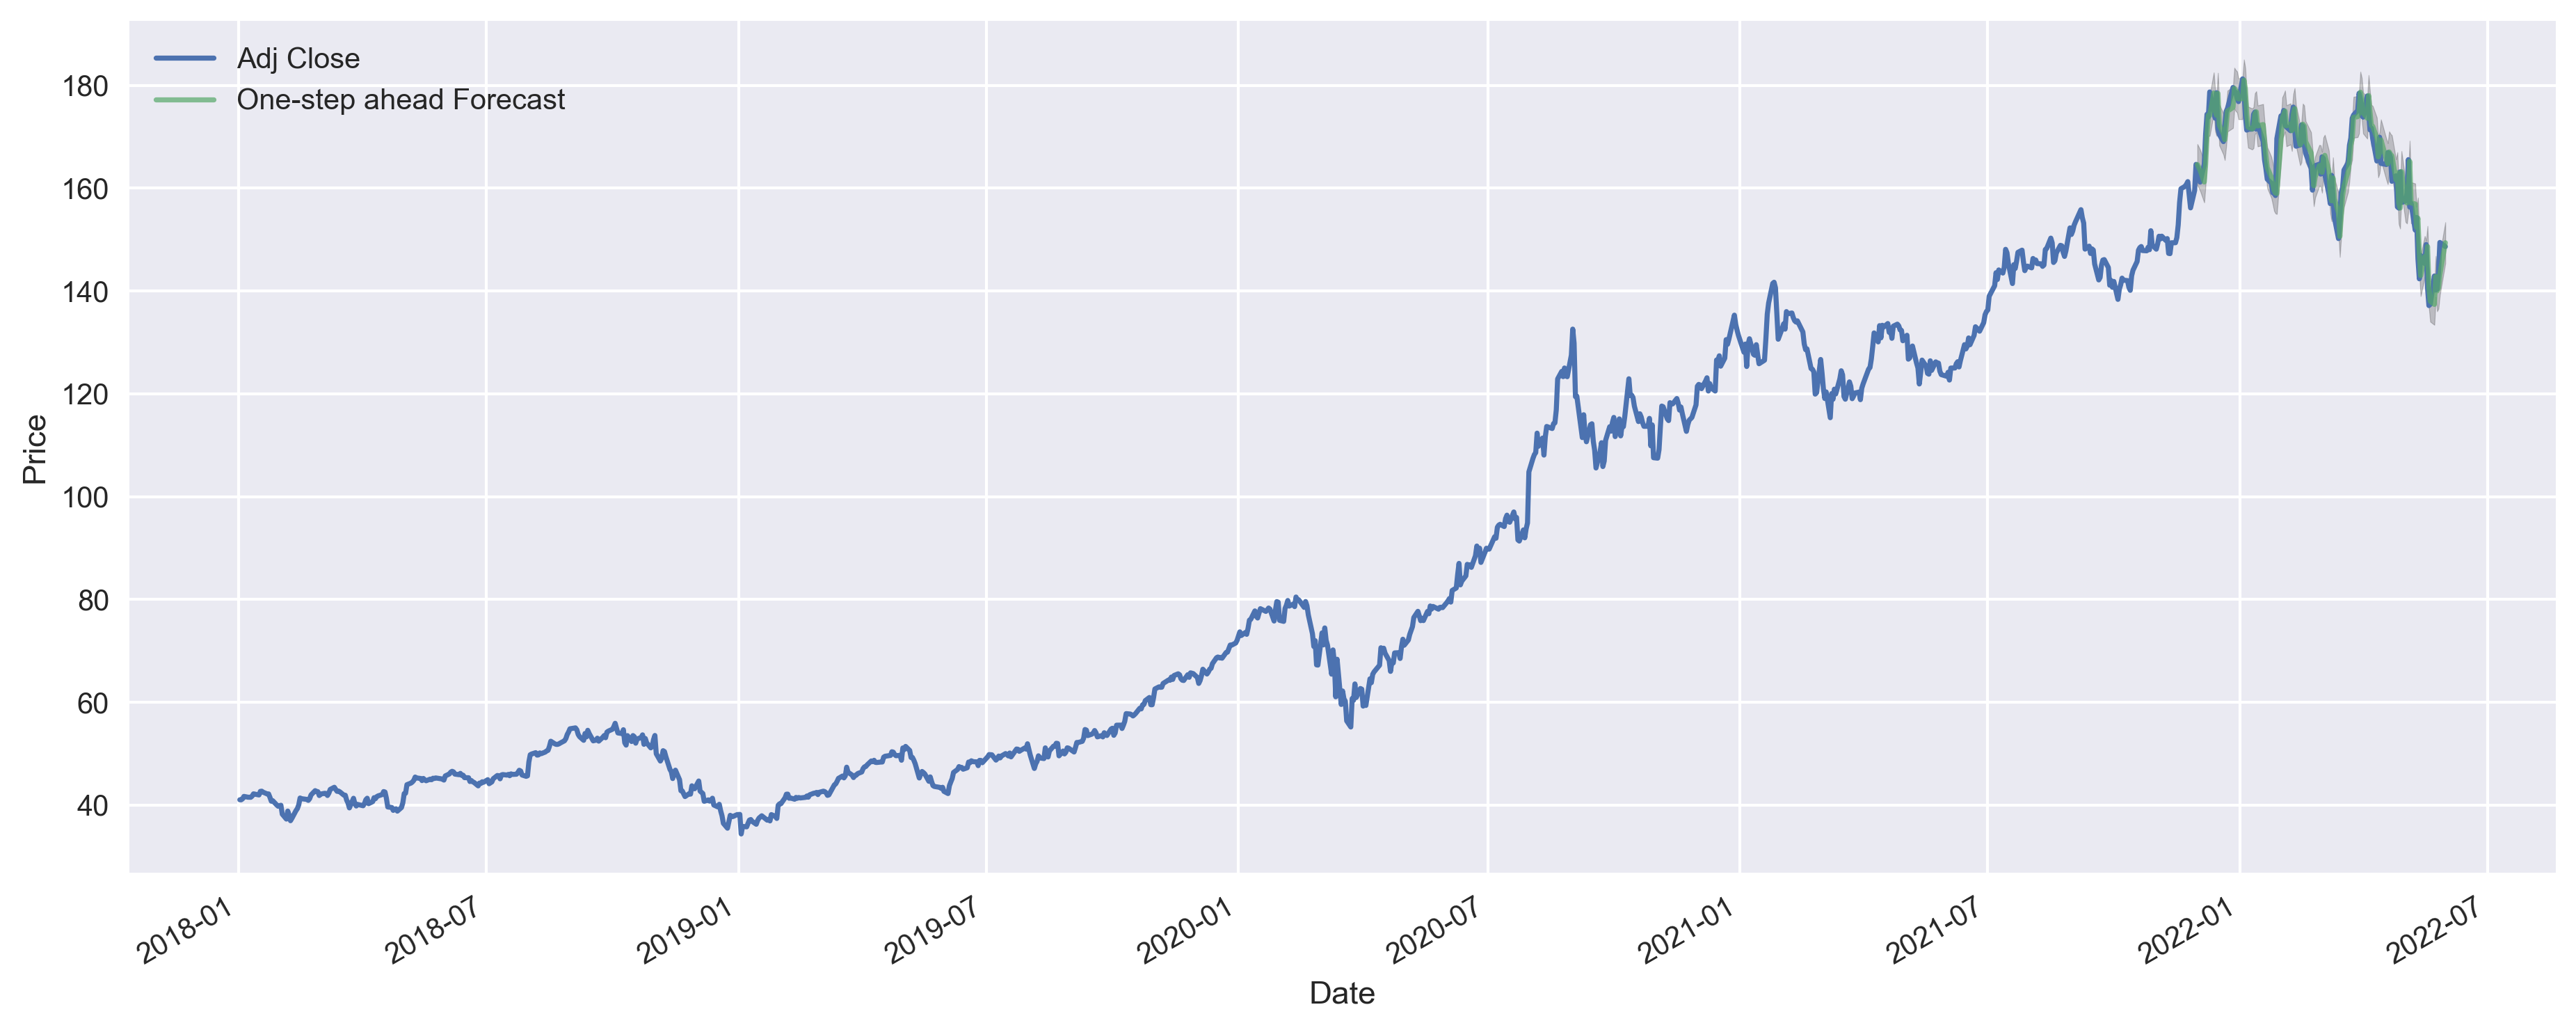

In [102]:
pred = results.get_prediction(start=pd.to_datetime('2021-12-01'), dynamic=False)
pred_ci = pred.conf_int()
y=data[['Adj Close']]
ax = y['2018':].plot(figsize=(15, 6), label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

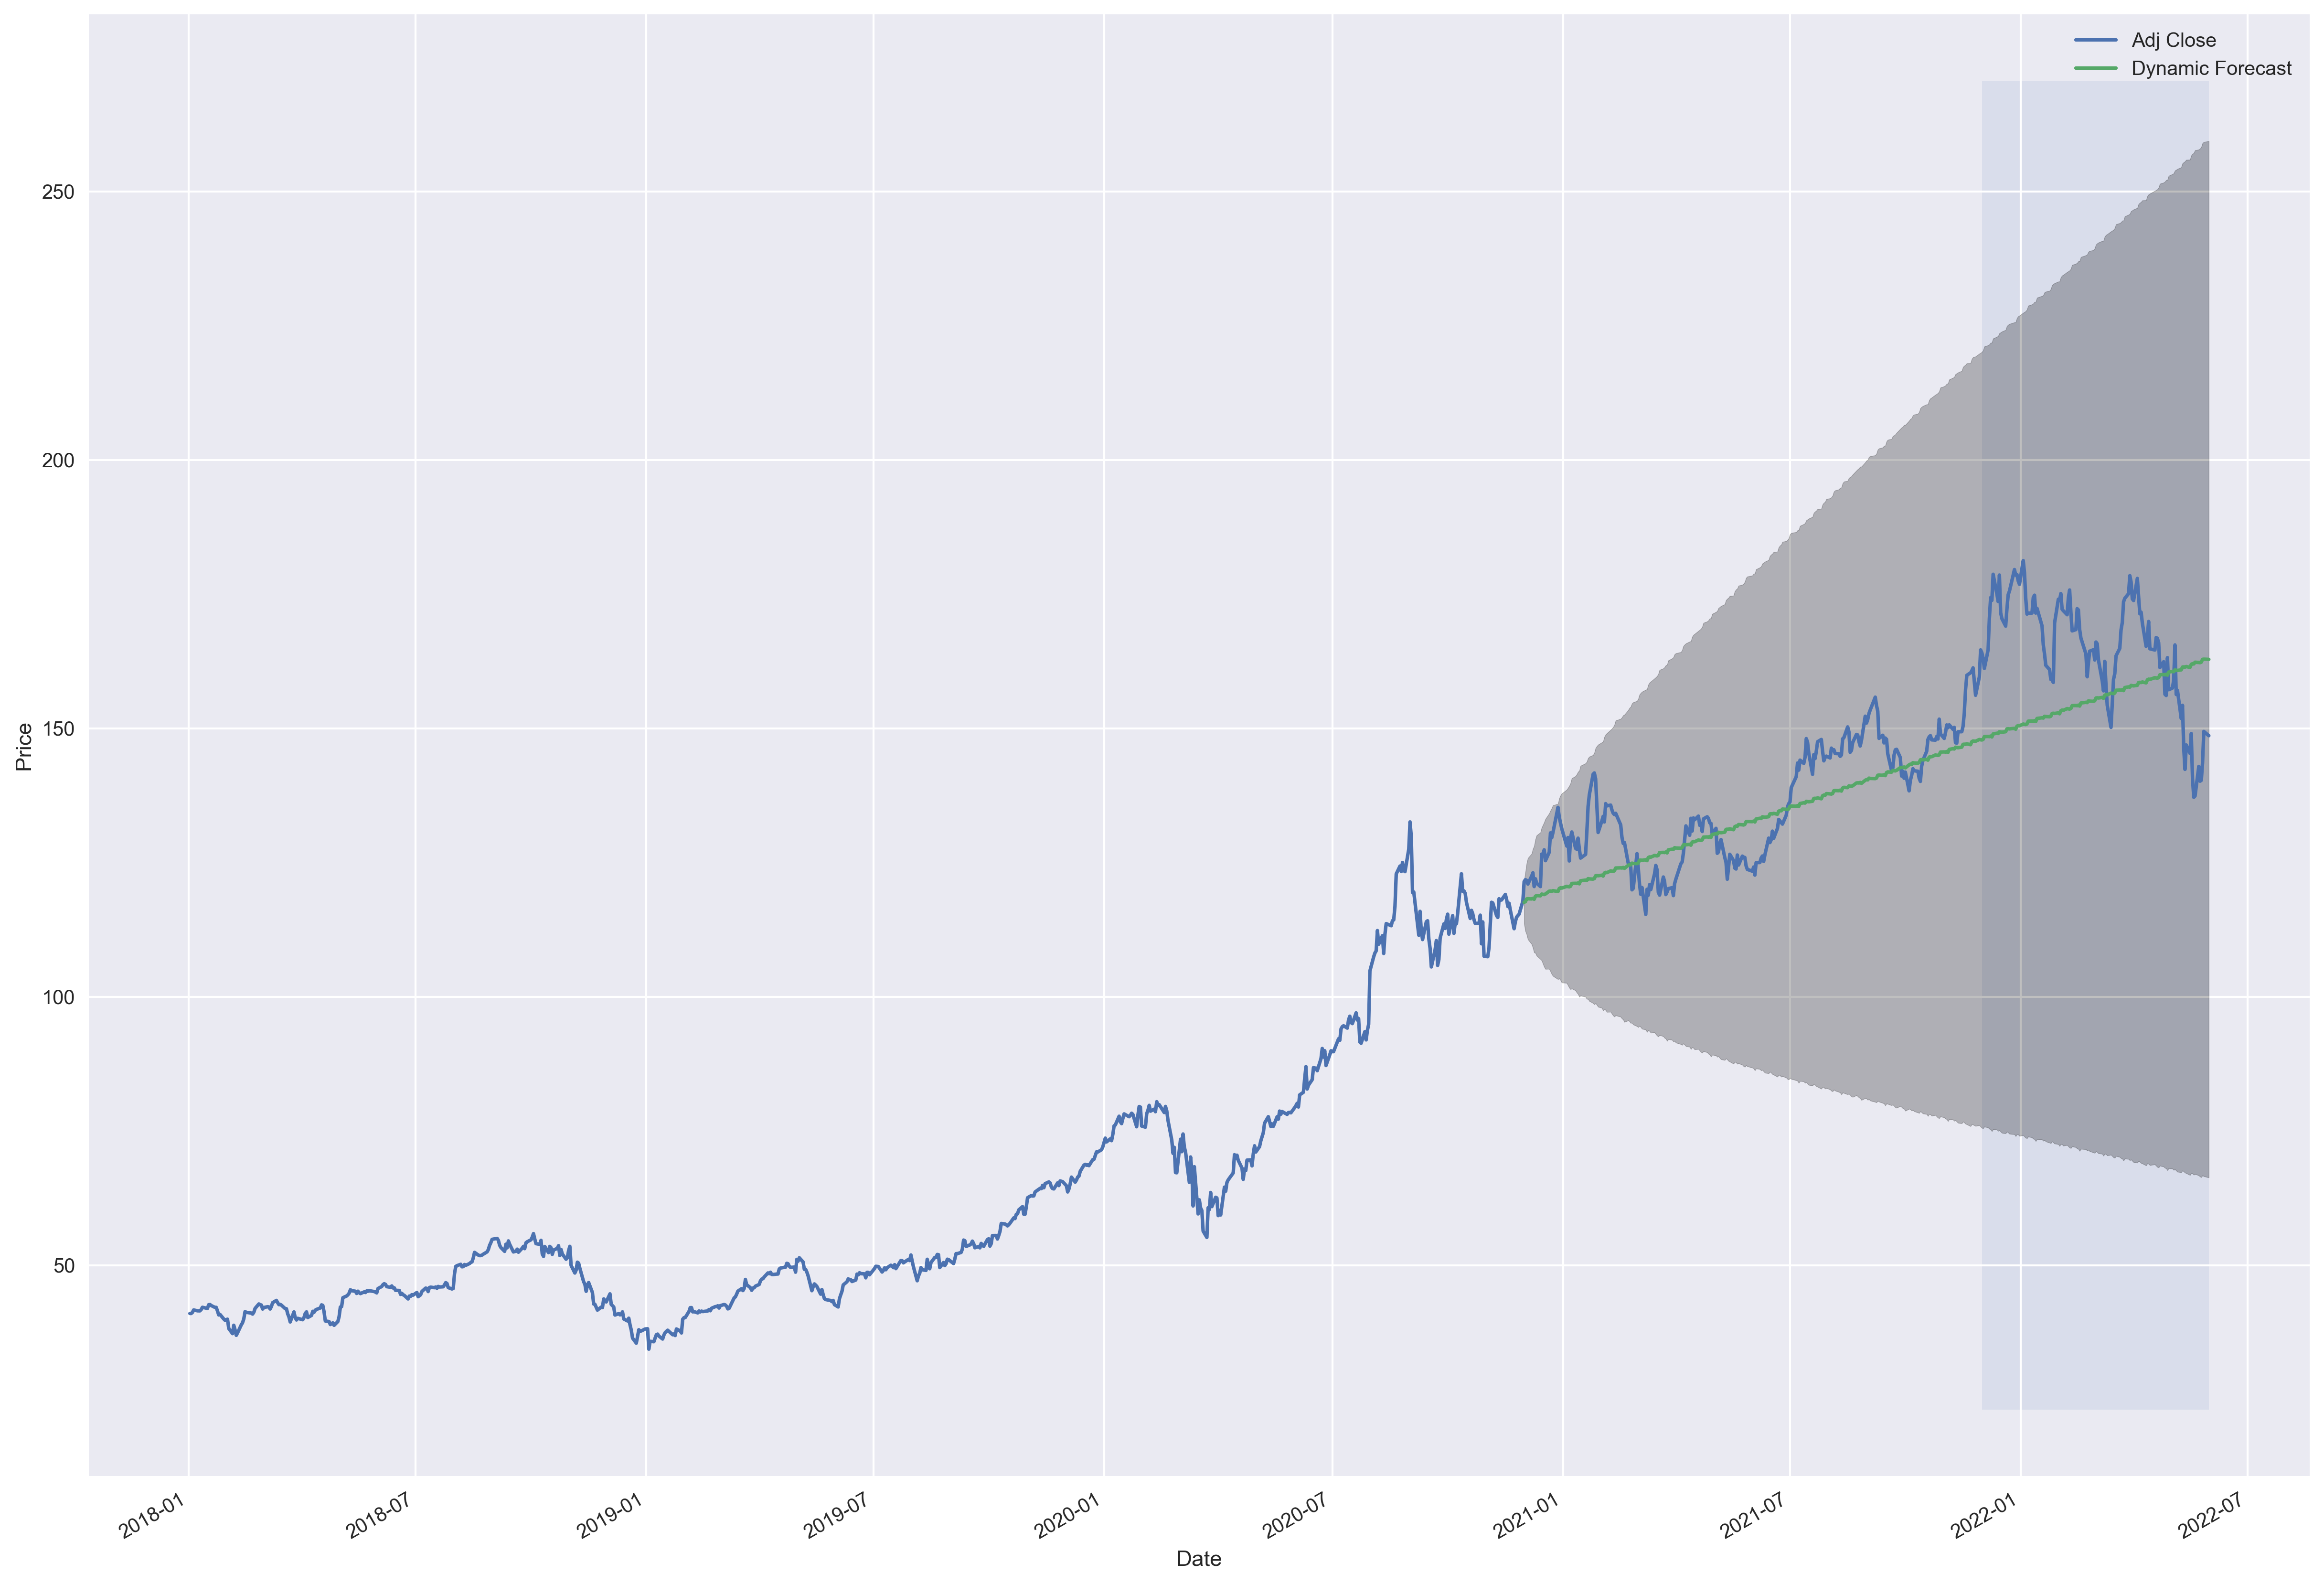

In [105]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-12-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
ax = y['2018':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
pred_dynamic_ci.iloc[:, 0],
pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-12-01'), y.index[-1],
alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [107]:
SMA1 = 42  
SMA2 = 252  

In [108]:
y

Adj Close
Date                  
2018-01-02   41.018433
2018-01-03   41.011276
2018-01-04   41.201778
2018-01-05   41.670876
2018-01-08   41.516098
...                ...
2022-05-24  140.165298
2022-05-25  140.325089
2022-05-26  143.580551
2022-05-27  149.432434
2022-05-31  148.633545

[1111 rows x 1 columns]

In [109]:
y['SMA1'] = y['Adj Close'].rolling(SMA1).mean()  
y['SMA2'] = y['Adj Close'].rolling(SMA2).mean()  

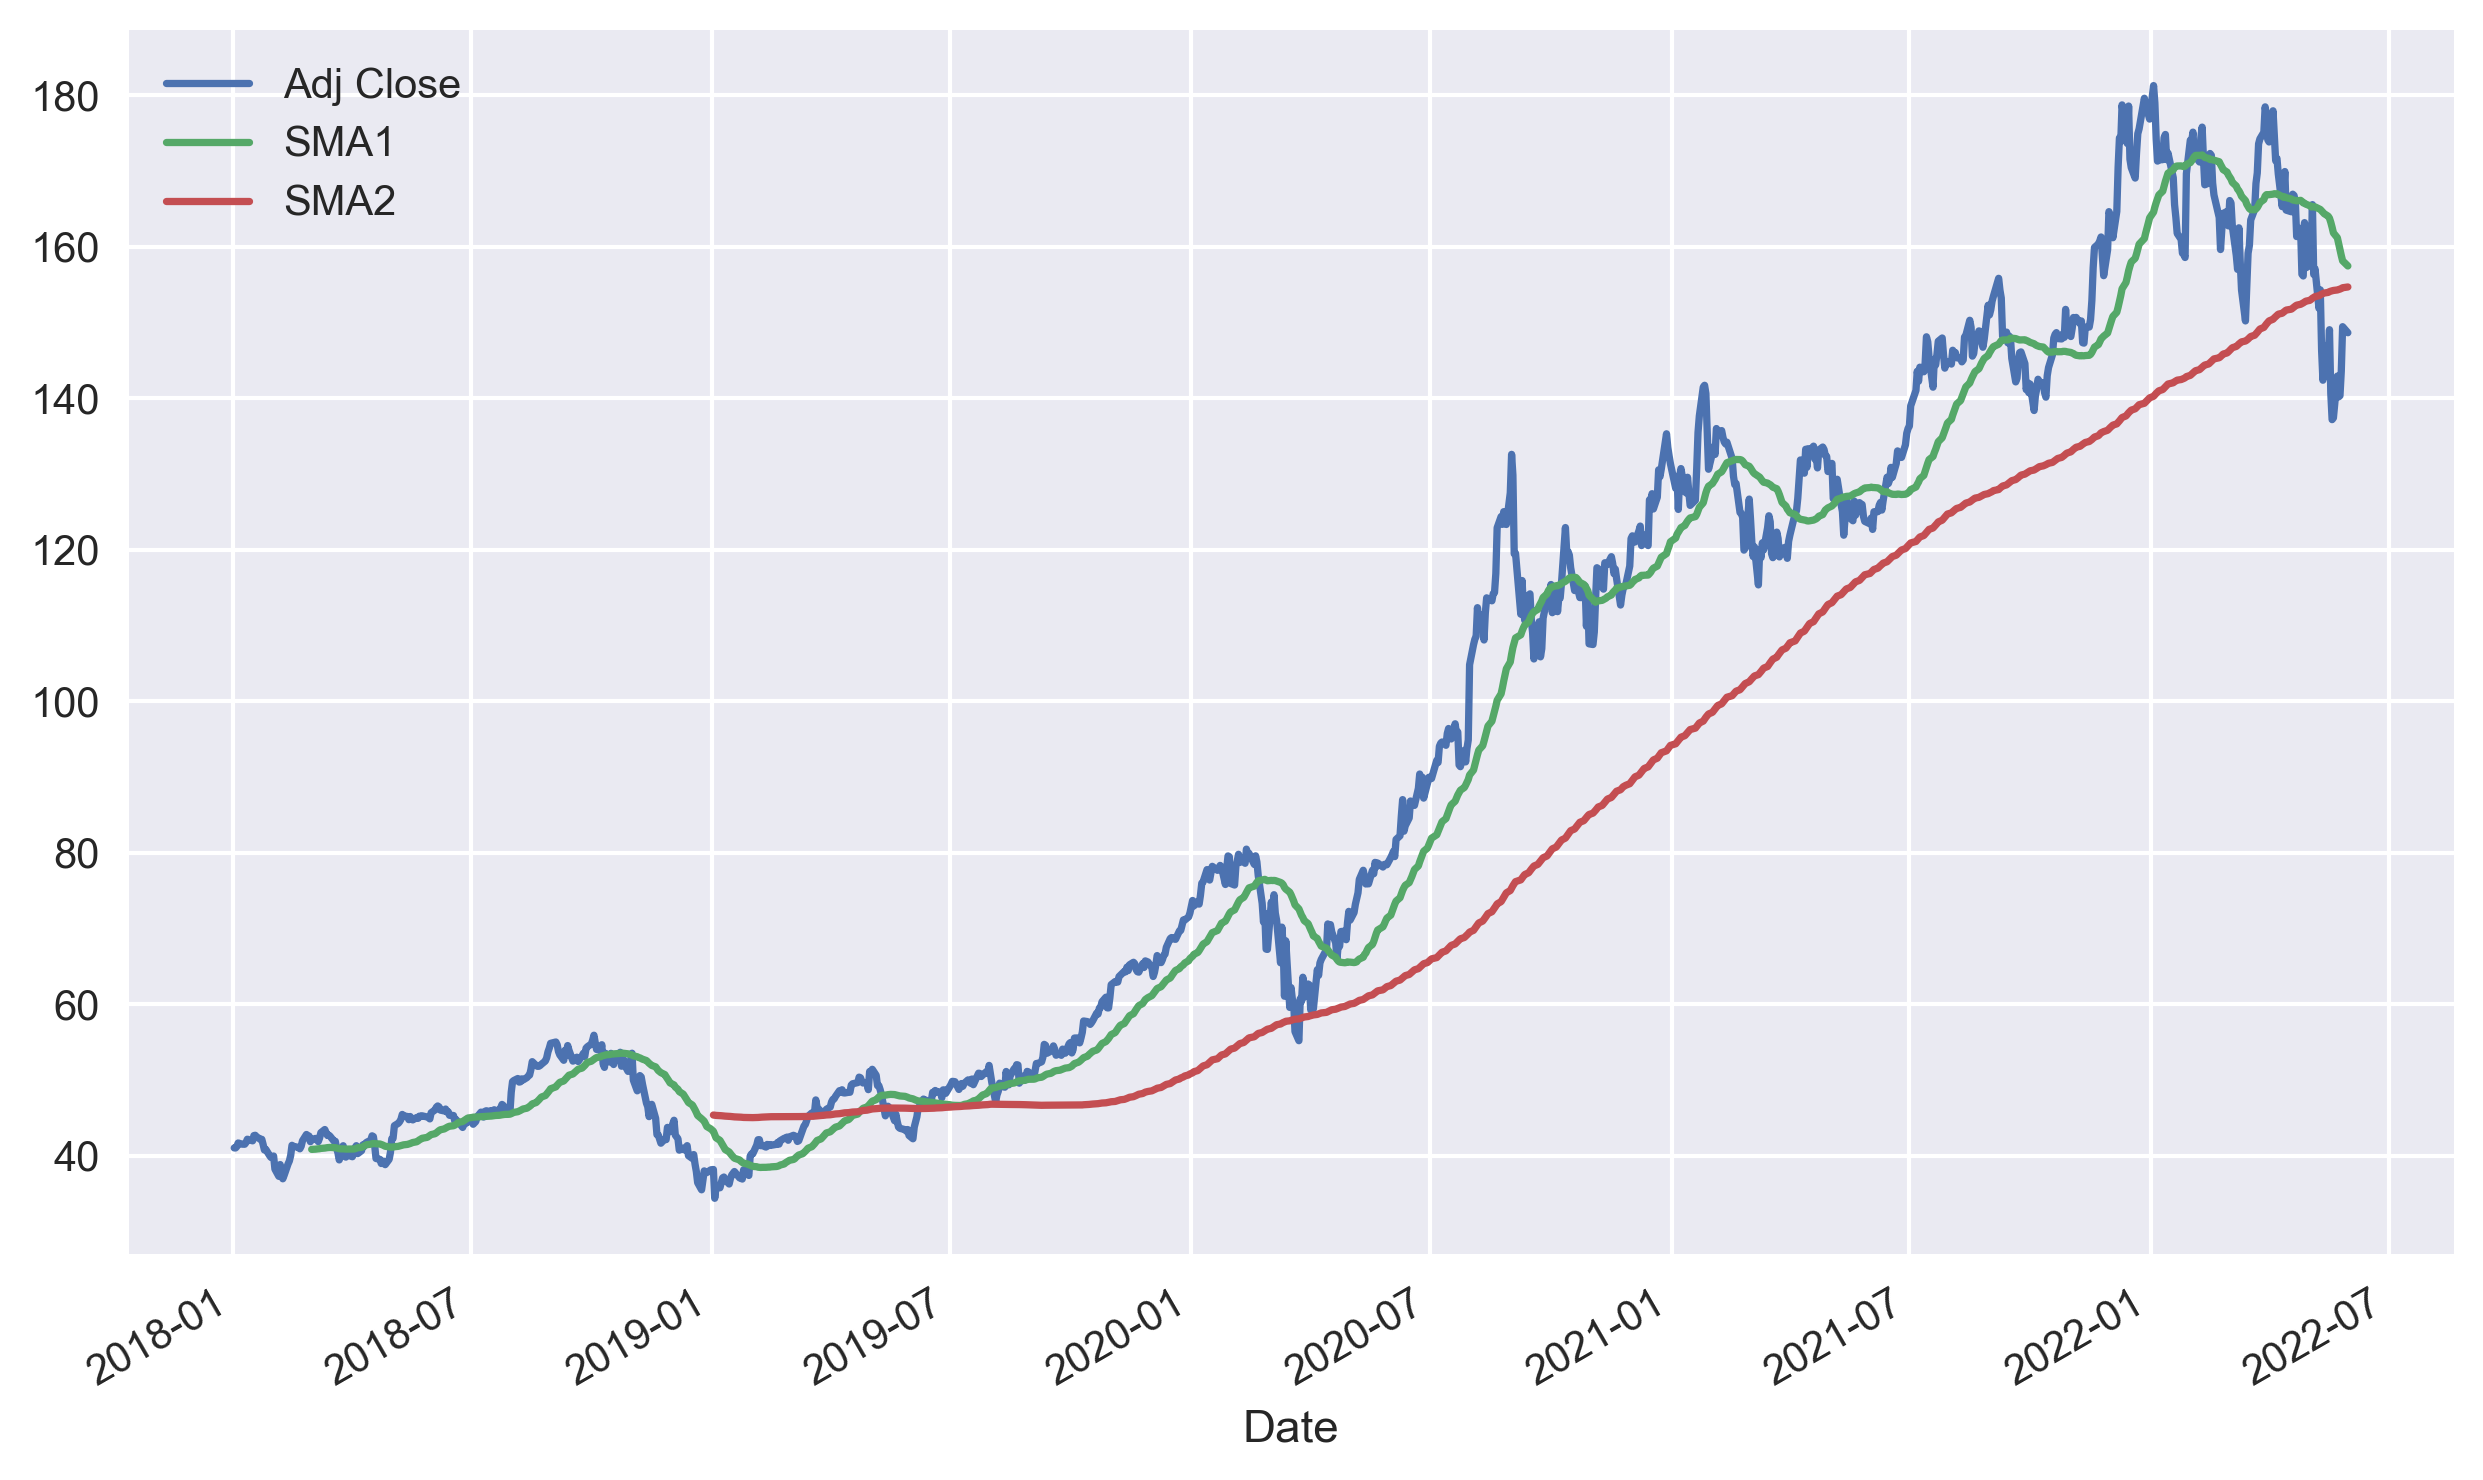

In [110]:
y.plot(figsize=(10, 6));

In [111]:
y.dropna(inplace=True)

In [112]:
y['Position'] = np.where(y['SMA1'] > y['SMA2'], 1, -1)  

In [113]:
y

Adj Close        SMA1        SMA2  Position
Date                                                    
2019-01-02   38.168350   43.213748   45.358689        -1
2019-01-03   34.366501   42.776920   45.332292        -1
2019-01-04   35.833580   42.355754   45.311746        -1
2019-01-07   35.753819   42.017217   45.290127        -1
2019-01-08   36.435402   41.728686   45.269351        -1
...                ...         ...         ...       ...
2022-05-24  140.165298  160.377521  154.336753         1
2022-05-25  140.325089  159.570459  154.393779         1
2022-05-26  143.580551  158.820016  154.469910         1
2022-05-27  149.432434  158.129132  154.571903         1
2022-05-31  148.633545  157.447479  154.672026         1

[860 rows x 4 columns]

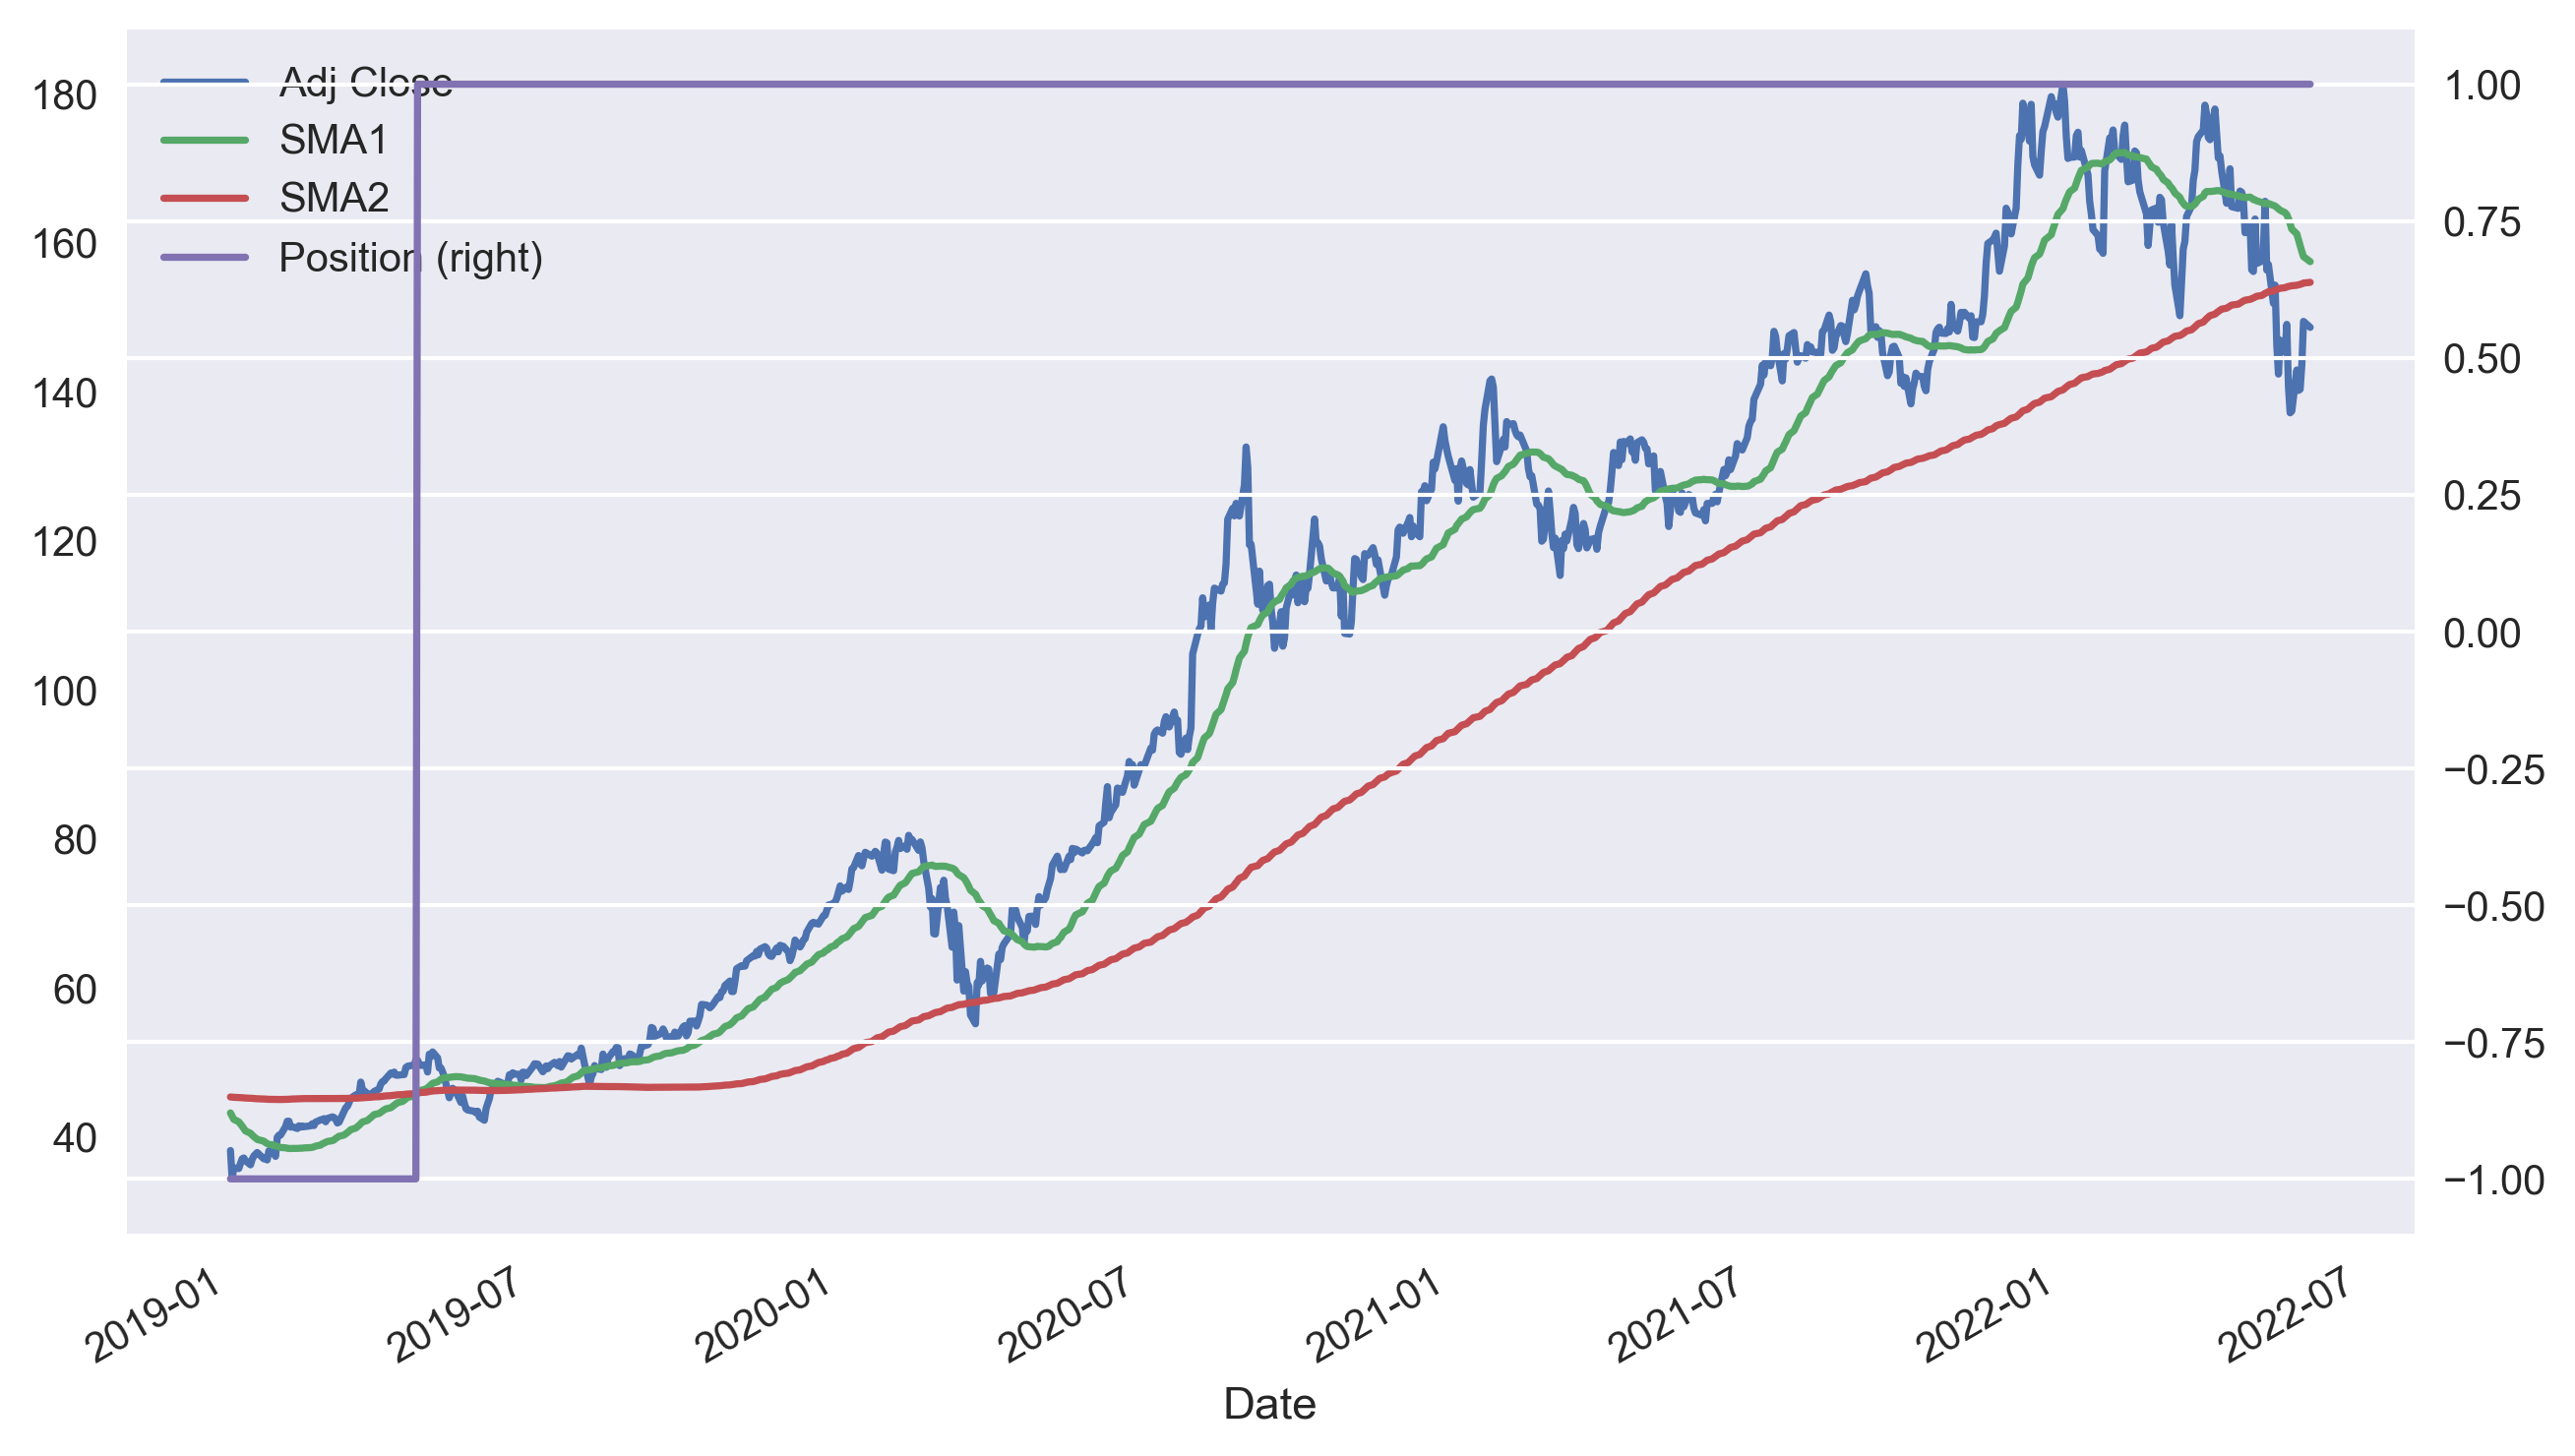

In [114]:
x = y.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

In [115]:
y['Returns'] = np.log(y['SMA1'] / y['SMA1'].shift(1)) 

In [116]:
y['Strategy'] = y['Position'].shift(1) * y['Returns']  

In [117]:
y.round(4).head()

Adj Close     SMA1     SMA2  Position  Returns  Strategy
Date                                                                
2019-01-02    38.1684  43.2137  45.3587        -1      NaN       NaN
2019-01-03    34.3665  42.7769  45.3323        -1  -0.0102    0.0102
2019-01-04    35.8336  42.3558  45.3117        -1  -0.0099    0.0099
2019-01-07    35.7538  42.0172  45.2901        -1  -0.0080    0.0080
2019-01-08    36.4354  41.7287  45.2694        -1  -0.0069    0.0069

In [118]:
y.dropna(inplace=True)
np.exp(y[['Returns', 'Strategy']].sum()) 
y[['Returns', 'Strategy']].std() * 252 ** 0.5  

Returns     0.047938
Strategy    0.048986
dtype: float64

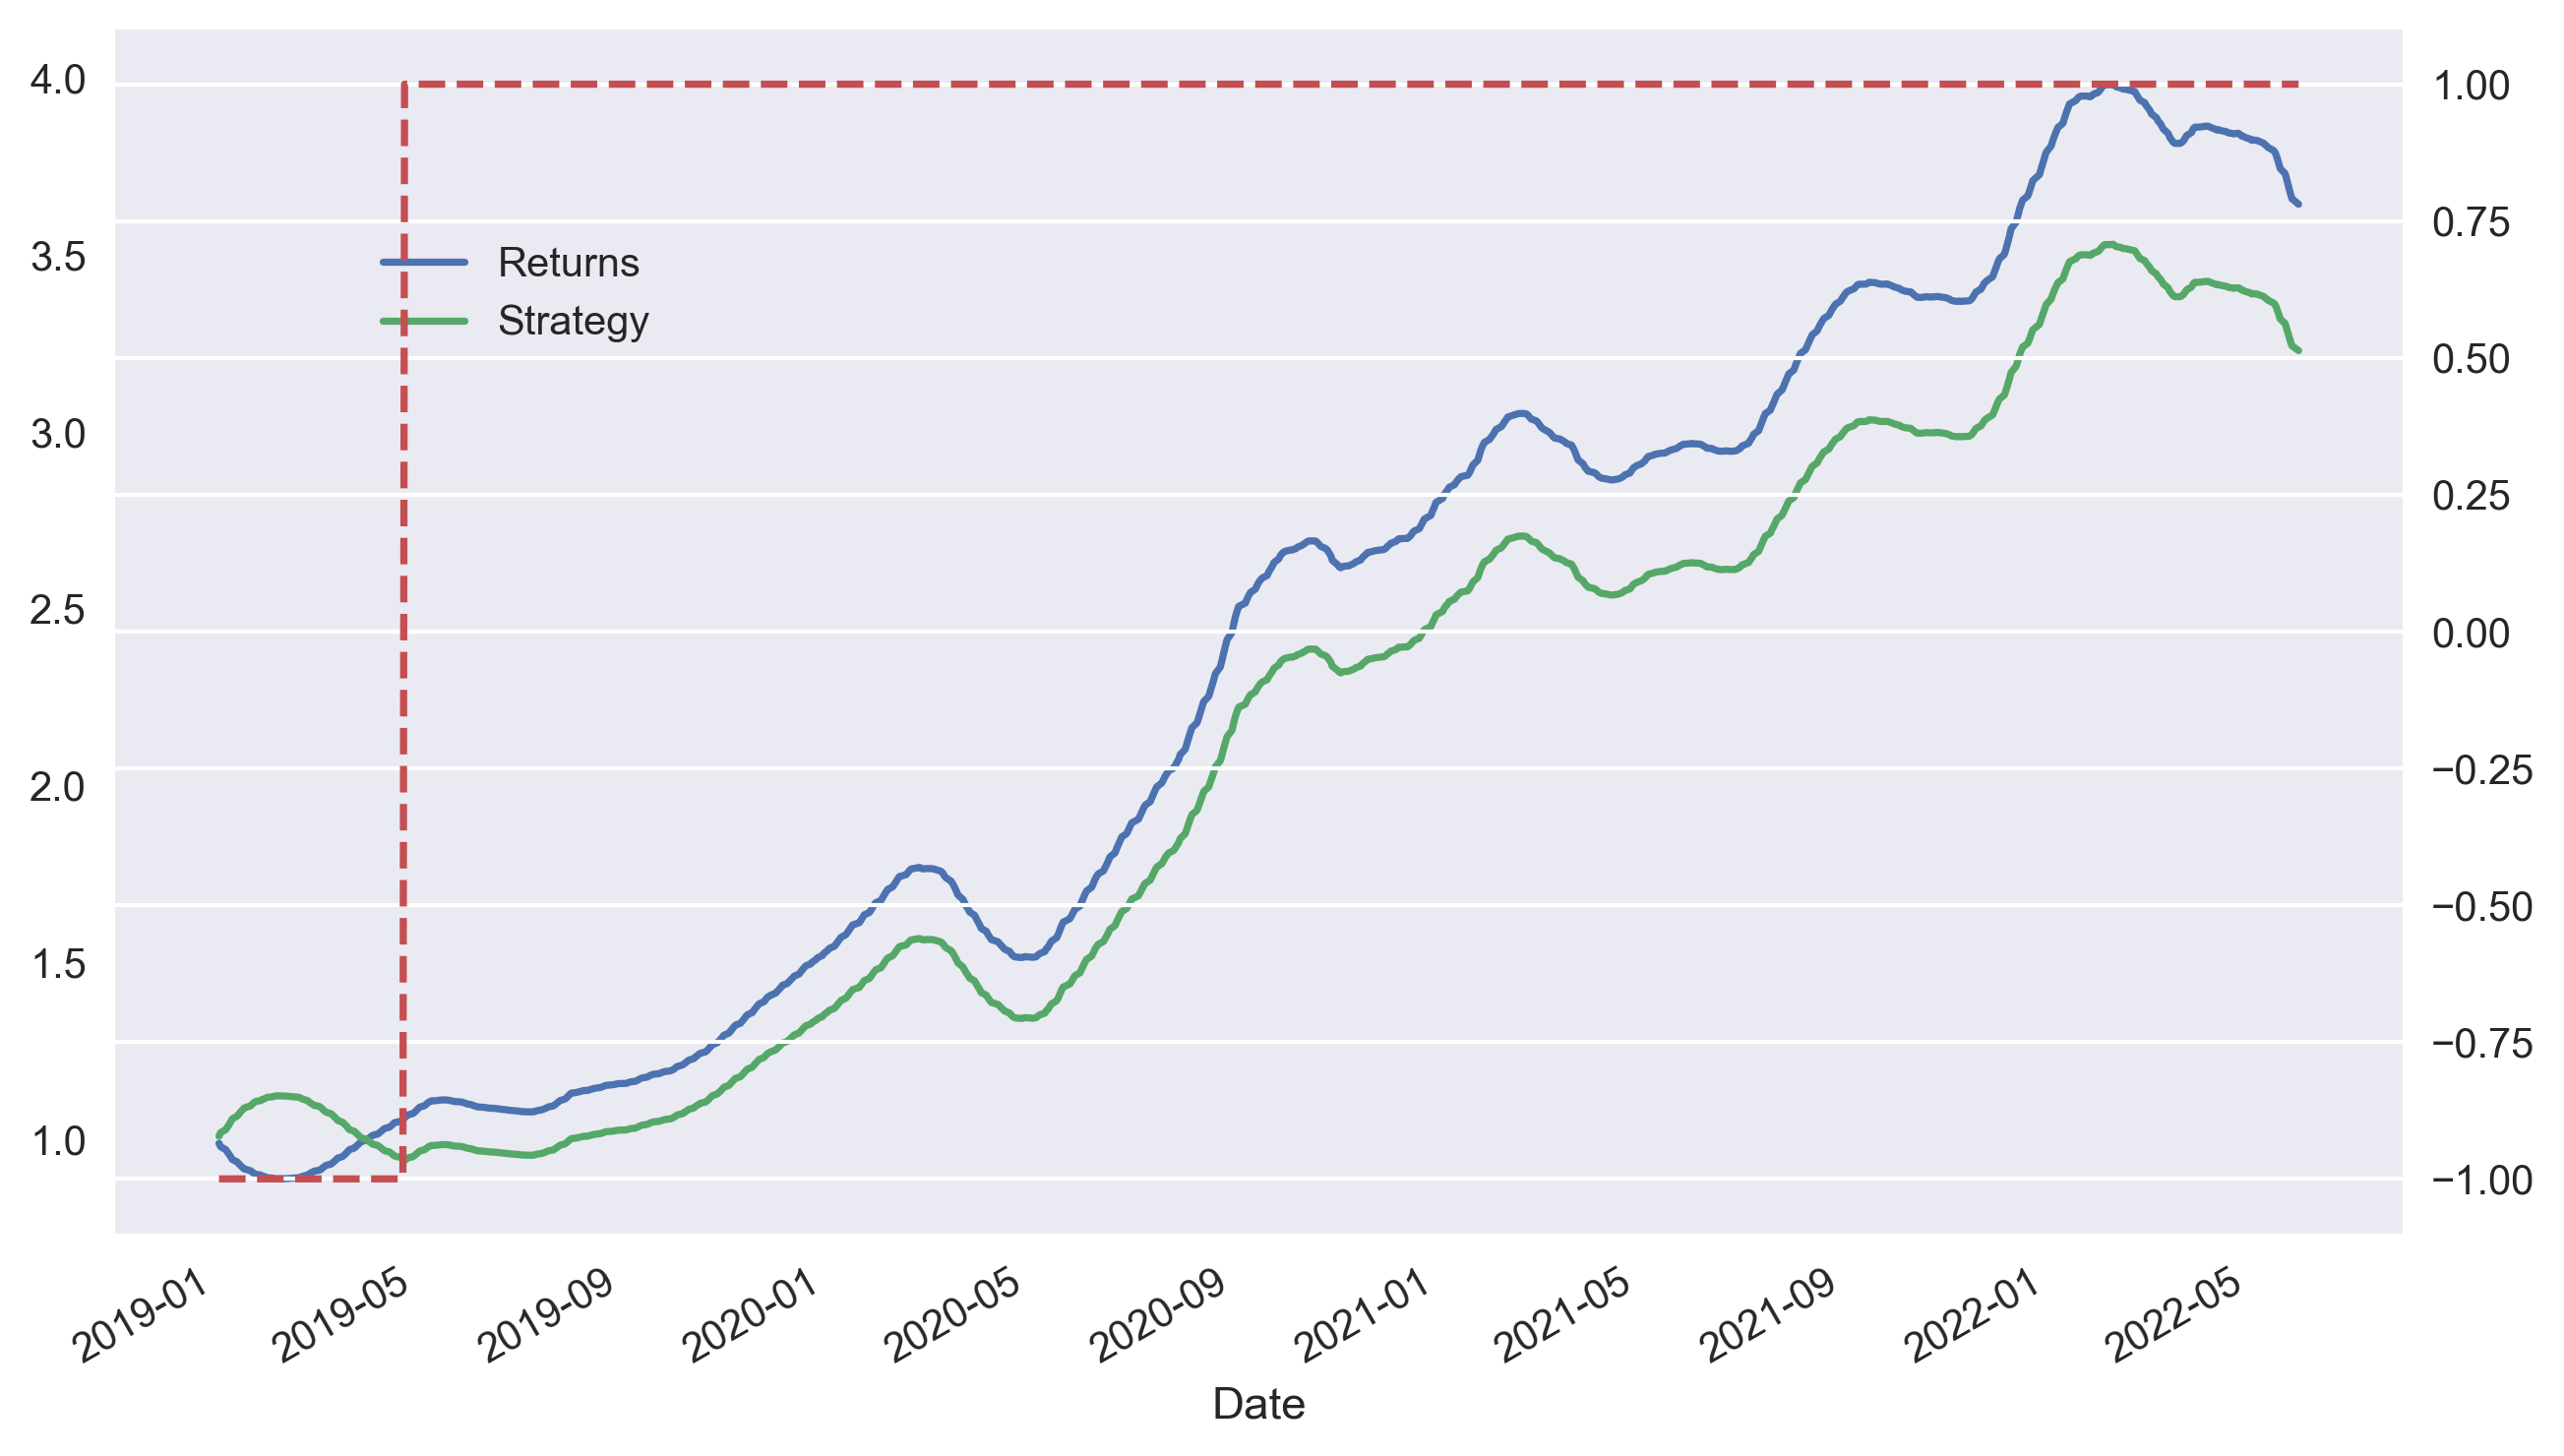

In [119]:
ax = y[['Returns', 'Strategy']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))
y['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

In [125]:

y[['Returns', 'Strategy']].std() * 252 ** 0.5  

Returns     0.047938
Strategy    0.048986
dtype: float64